In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
!pip install networkx tqdm matplotlib numpy pandas scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.0/494.0 kB 9.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.9/750.9 kB 15.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 k

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import os

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOp

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]


Processing...
Done!


In [ ]:
# === STEP 4: Define a Basic GCN Model (baseline) ===
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
# === STEP 5: Train the Model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    logits = model(data)
    masks = ['train_mask', 'val_mask', 'test_mask']
    accs = []
    for mask in masks:
        mask_idx = data[mask]
        pred = logits[mask_idx].max(1)[1]
        acc = pred.eq(data.y[mask_idx]).sum().item() / mask_idx.sum().item()
        accs.append(acc)
    return accs


In [ ]:
# Training loop
for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')


Epoch 000, Loss: 1.9502, Train: 0.6643, Val: 0.3720, Test: 0.4290
Epoch 020, Loss: 0.2153, Train: 1.0000, Val: 0.7800, Test: 0.7990
Epoch 040, Loss: 0.0611, Train: 1.0000, Val: 0.7740, Test: 0.7960
Epoch 060, Loss: 0.0370, Train: 1.0000, Val: 0.7860, Test: 0.8000
Epoch 080, Loss: 0.0448, Train: 1.0000, Val: 0.7760, Test: 0.8040
Epoch 100, Loss: 0.0313, Train: 1.0000, Val: 0.7760, Test: 0.8070
Epoch 120, Loss: 0.0353, Train: 1.0000, Val: 0.7720, Test: 0.7970
Epoch 140, Loss: 0.0245, Train: 1.0000, Val: 0.7680, Test: 0.8050
Epoch 160, Loss: 0.0397, Train: 1.0000, Val: 0.7700, Test: 0.8050
Epoch 180, Loss: 0.0209, Train: 1.0000, Val: 0.7820, Test: 0.8050


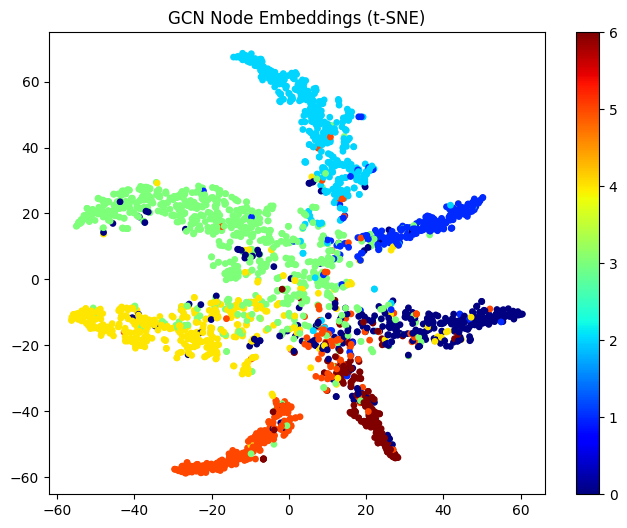

In [ ]:
# === STEP 6: Visualize Embeddings (Optional) ===
def plot_embedding(model, data):
    model.eval()
    x = model(data).detach().cpu().numpy()
    y = data.y.cpu().numpy()
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2)
    x_tsne = tsne.fit_transform(x)

    plt.figure(figsize=(8,6))
    plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y, cmap="jet", s=15)
    plt.title("GCN Node Embeddings (t-SNE)")
    plt.colorbar()
    plt.show()

plot_embedding(model, data)

In [ ]:
# === STEP A: Synthetic Graph Fingerprint Creation ===
from torch_geometric.data import Data
import torch

def create_fingerprint_graph(num_nodes=10, feature_dim=dataset.num_node_features):
    # Create random edges (sparse graph)
    edge_index = torch.randint(0, num_nodes, (2, num_nodes), dtype=torch.long)

    # Random features for each node (uniform between 0 and 1)
    x = torch.rand((num_nodes, feature_dim), dtype=torch.float)

    # Dummy labels (not used for training)
    y = torch.zeros(num_nodes, dtype=torch.long)

    # Create a PyG Data object
    fingerprint = Data(x=x, edge_index=edge_index, y=y)
    return fingerprint

# Create 5 fingerprint graphs
fingerprints = [create_fingerprint_graph() for _ in range(5)]

In [ ]:
# Put model in eval mode
model.eval()

# Move to same device
for fp in fingerprints:
    fp = fp.to(device)

# Collect model responses
fingerprint_outputs = []

for fp in fingerprints:
    with torch.no_grad():
        out = model(fp.to(device))
        fingerprint_outputs.append(out.cpu().numpy())

# Convert to array of response vectors
import numpy as np
fingerprint_outputs = np.array(fingerprint_outputs)
print("Fingerprint Output Shape:", fingerprint_outputs.shape)


Fingerprint Output Shape: (5, 10, 7)


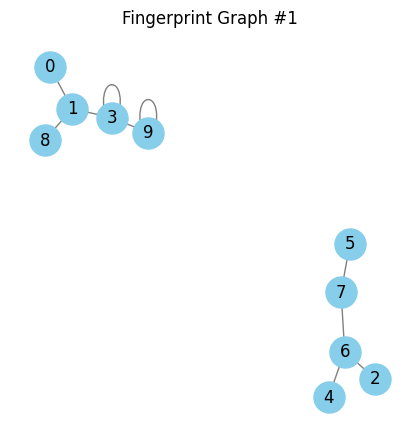

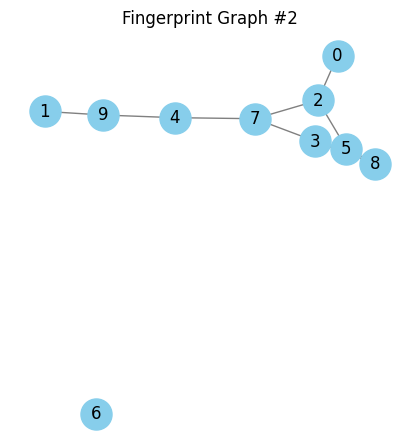

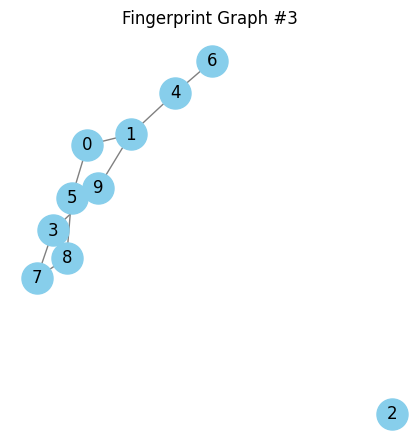

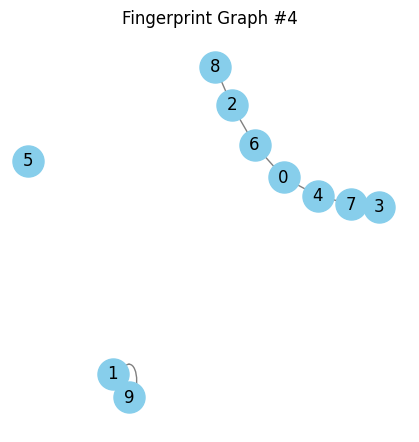

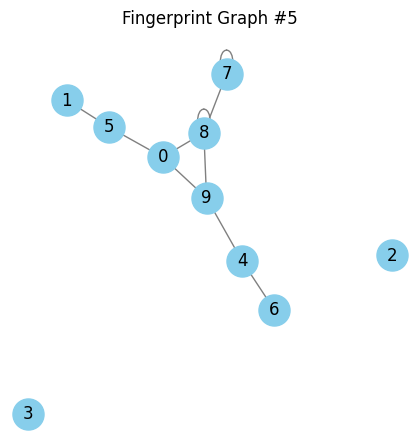

In [ ]:

# visualising fingerprint graphs
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def visualize_fingerprint_graph(fingerprint, idx=0):
    G = to_networkx(fingerprint, to_undirected=True)
    plt.figure(figsize=(4, 4))
    nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500)
    plt.title(f"Fingerprint Graph #{idx}")
    plt.show()

# Visualize all 5 fingerprints
for i, fp in enumerate(fingerprints):
    visualize_fingerprint_graph(fp, idx=i+1)


In [ ]:
# Simulate a stolen model trained using soft labels from original GCN
surrogate_model = GCN().to(device)
surrogate_optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=0.01, weight_decay=5e-4)

# Use soft outputs from original model as targets
soft_targets = model(data).detach()

def train_surrogate():
    surrogate_model.train()
    surrogate_optimizer.zero_grad()
    out = surrogate_model(data)
    loss = F.kl_div(out[data.train_mask], soft_targets[data.train_mask], reduction='batchmean', log_target=True)
    loss.backward()
    surrogate_optimizer.step()
    return loss.item()

for epoch in range(200):
    loss = train_surrogate()
    if epoch % 50 == 0:
        print(f"[Surrogate] Epoch {epoch} - Loss: {loss:.4f}")


[Surrogate] Epoch 0 - Loss: 1.9181
[Surrogate] Epoch 50 - Loss: 0.0349
[Surrogate] Epoch 100 - Loss: 0.0359
[Surrogate] Epoch 150 - Loss: 0.0205


In [ ]:
# Compare GCN and surrogate outputs on fingerprints
original_outputs = []
surrogate_outputs = []

model.eval()
surrogate_model.eval()

for fp in fingerprints:
    with torch.no_grad():
        original = model(fp.to(device)).cpu().numpy()
        surrogate = surrogate_model(fp.to(device)).cpu().numpy()
        original_outputs.append(original)
        surrogate_outputs.append(surrogate)

# Compute average L2 distances
l2_dists = [np.linalg.norm(orig - sur) for orig, sur in zip(original_outputs, surrogate_outputs)]
print("Average L2 distances between original and surrogate on fingerprint graphs:")
print(np.round(l2_dists, 4))


Average L2 distances between original and surrogate on fingerprint graphs:
[154.2611 157.3134 134.4788 159.2394 132.1054]


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Flatten each graph's output into a 1D vector
def flatten_outputs(output_list):
    return [out.flatten() for out in output_list]

X = flatten_outputs(original_outputs + surrogate_outputs)
y = [1] * len(original_outputs) + [0] * len(surrogate_outputs)  # 1 = real, 0 = stolen

# Train Univerifier
univerifier = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
univerifier.fit(X, y)

# Eval
y_pred = univerifier.predict(X)
print("Univerifier Results:\n", classification_report(y, y_pred))


Univerifier Results:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



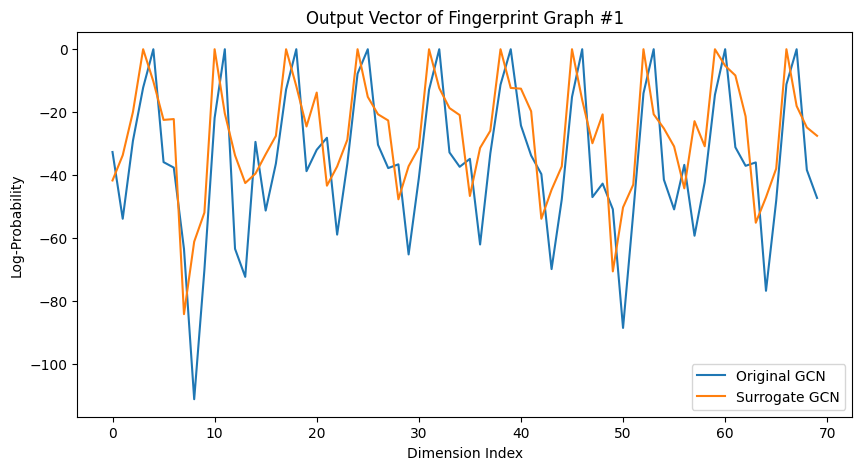

In [ ]:
import seaborn as sns

# Plot for first fingerprint (real vs. surrogate)
fp_idx = 0
real_out = original_outputs[fp_idx].flatten()
sur_out = surrogate_outputs[fp_idx].flatten()

plt.figure(figsize=(10, 5))
sns.lineplot(data=real_out, label="Original GCN")
sns.lineplot(data=sur_out, label="Surrogate GCN")
plt.title("Output Vector of Fingerprint Graph #1")
plt.xlabel("Dimension Index")
plt.ylabel("Log-Probability")
plt.legend()
plt.show()


In [ ]:
# Simulate a set of irrelevant GNNs (different init, trained from scratch)
irrelevant_models = []

for _ in range(5):  # Feel free to expand to 10–20
    model_ir = GCN().to(device)
    optimizer_ir = torch.optim.Adam(model_ir.parameters(), lr=0.01, weight_decay=5e-4)

    # Standard training
    for _ in range(100):
        model_ir.train()
        optimizer_ir.zero_grad()
        out = model_ir(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer_ir.step()

    irrelevant_models.append(model_ir)


In [ ]:
# Collect outputs on fingerprints from irrelevant models
irrelevant_outputs = []

for model_ir in irrelevant_models:
    model_ir.eval()
    model_outputs = []
    for fp in fingerprints:
        with torch.no_grad():
            out = model_ir(fp.to(device)).cpu().numpy()
            model_outputs.append(out)
    irrelevant_outputs.append(model_outputs)

# Flatten to same structure: list of np arrays
irrelevant_outputs_flat = [o.flatten() for graph_out in irrelevant_outputs for o in graph_out]


Updated Univerifier Results:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        25
           1       0.00      0.00      0.00         5

    accuracy                           0.83        30
   macro avg       0.42      0.50      0.45        30
weighted avg       0.69      0.83      0.76        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


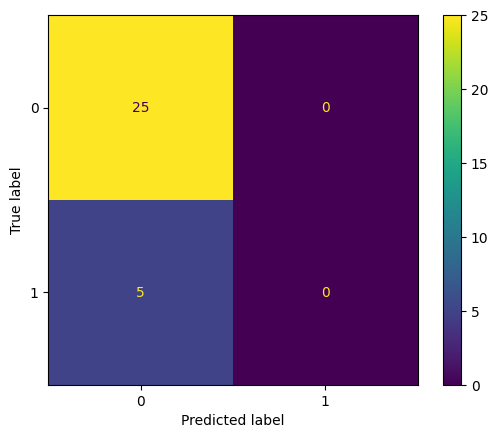

In [ ]:
# Flatten all output vectors
X = flatten_outputs(original_outputs) + flatten_outputs(surrogate_outputs) + irrelevant_outputs_flat
y = [1]*len(original_outputs) + [0]*len(surrogate_outputs) + [-1]*len(irrelevant_outputs_flat)  # 1 = real, 0 = pirated, -1 = irrelevant

# Relabel to binary task: pirated vs. irrelevant (ownership check)
X_bin = flatten_outputs(surrogate_outputs + irrelevant_outputs_flat)
y_bin = [1]*len(surrogate_outputs) + [0]*len(irrelevant_outputs_flat)

from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Retrain Univerifier
univerifier_bin = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
univerifier_bin.fit(X_bin, y_bin)
y_pred_bin = univerifier_bin.predict(X_bin)

print("Updated Univerifier Results:\n", classification_report(y_bin, y_pred_bin))
ConfusionMatrixDisplay.from_predictions(y_bin, y_pred_bin)


In [ ]:
import pandas as pd

# Save all outputs into one CSV file
df = pd.DataFrame({
    'ModelType': ['Real']*len(original_outputs) + ['Pirated']*len(surrogate_outputs) + ['Irrelevant']*len(irrelevant_outputs_flat),
    'L2Norm': l2_dists + [np.nan]*len(surrogate_outputs) + [np.nan]*len(irrelevant_outputs_flat),
    'OutputVec': [x.tolist() for x in X]
})

df.to_csv("gnnfingers_outputs.csv", index=False)
print("Saved outputs to 'gnnfingers_outputs.csv'")


Saved outputs to 'gnnfingers_outputs.csv'


In [ ]:
#Building the univerifier model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


In [ ]:
class Univerifier(nn.Module):
    def __init__(self, input_dim):
        super(Univerifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 2),  # Output: [pirated, irrelevant]
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def create_and_train_gcn(seed=0, fine_tune=False, base_model=None, data=None, epochs=100):
    torch.manual_seed(seed)
    model = GCN().to(device)

    if fine_tune and base_model is not None:
        model.load_state_dict(base_model.state_dict())  # Copy weights
        model.train()
    else:
        model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for _ in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    return model


In [ ]:
# Train your base model first
base_model = GCN().to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.01, weight_decay=5e-4)
for _ in range(200):  # Original full training
    base_model.train()
    optimizer.zero_grad()
    out = base_model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Generate pirated models (fine-tuned versions of base)
pirated_models = [create_and_train_gcn(seed=i, fine_tune=True, base_model=base_model, data=data, epochs=10) for i in range(20)]


# Generate irrelevant models (trained from scratch with different seeds)
irrelevant_models = [create_and_train_gcn(seed=100+i, fine_tune=False, base_model=None, data=data, epochs=100) for i in range(20)]




In [ ]:
# Store output vectors
fingerprint_outputs_pos = []
fingerprint_outputs_neg = []

# Evaluate pirated (positive) models
for model in pirated_models:
    model.eval()
    outputs = []
    for fp in fingerprints:
        with torch.no_grad():
            fp = fp.to(device)
            out = model(fp)
            outputs.append(out.cpu().numpy())
    fingerprint_outputs_pos.append(np.concatenate(outputs))

# Evaluate irrelevant (negative) models
for model in irrelevant_models:
    model.eval()
    outputs = []
    for fp in fingerprints:
        with torch.no_grad():
            fp = fp.to(device)
            out = model(fp)
            outputs.append(out.cpu().numpy())
    fingerprint_outputs_neg.append(np.concatenate(outputs))


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Imports & Setup
# ─────────────────────────────────────────────────────────────────────────────

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ─────────────────────────────────────────────────────────────────────────────
# 2. Fingerprint‐Generation Function
#
# Based on §3.3 of You et al. (2024), we generate N small random graphs
# (graph‐fingerprints) whose structure will be used to probe each GNN.
# Here, we create an “ablation” style fingerprint: random Erdos–Rényi graphs
# with controlled edge‐density and node features sampled from a normal distribution.
# ─────────────────────────────────────────────────────────────────────────────

def generate_ablation_fingerprints(N, num_nodes=10, edge_prob=0.3, feature_dim=16, seed=42):
    """
    Generate N small random graphs as “fingerprint” inputs.
    Each graph has:
      - num_nodes nodes
      - adjacency from Erdos–Rényi with probability=edge_prob
      - node features x ∈ R^{num_nodes × feature_dim} sampled ~ N(0, 1)
    Returns a list of torch_geometric.data.Data objects.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    fingerprints = []

    for i in range(N):
        # Generate a random Erdos–Rényi graph
        edge_index = erdos_renyi_graph(num_nodes, edge_prob)

        # Node features: num_nodes × feature_dim, sampled from N(0,1)
        x = torch.randn((num_nodes, feature_dim), dtype=torch.float32)

        # Create Data object
        data = Data(x=x, edge_index=edge_index)
        fingerprints.append(data)

    return fingerprints

# Example usage: generate 50 fingerprint graphs
N_FINGERPRINTS = 50
fingerprints = generate_ablation_fingerprints(
    N=N_FINGERPRINTS,
    num_nodes=10,
    edge_prob=0.3,
    feature_dim=16,
    seed=42
)
print(f"Generated {len(fingerprints)} fingerprint graphs.")


# ─────────────────────────────────────────────────────────────────────────────
# 3. Load / Define Positive & Negative Models
#
# “Positive” models = obfuscated or pirated variants of the target GNN.
# “Negative” models = independently trained (irrelevant) GNNs.
#
# In practice, you would train or load M positive models and K negative models.
# Here, we provide placeholder functions. Replace them with your actual training
# or loading pipeline so that each list contains trained PyTorch‐GNN instances.
# ─────────────────────────────────────────────────────────────────────────────

def load_positive_models(model_dir):
    """
    Placeholder: load M positive (pirated) GNNs from `model_dir`.
    Return a Python list of PyTorch model instances, each moved to `device`.
    """
    positive_models = []
    # Example: assume files named “pos_model_1.pth”, “pos_model_2.pth”, …
    # for fname in os.listdir(model_dir):
    #     if fname.startswith("pos_model_") and fname.endswith(".pth"):
    #         model = YourGNNClass(...)              # instantiate architecture
    #         model.load_state_dict(torch.load(os.path.join(model_dir, fname)))
    #         model.to(device).eval()
    #         positive_models.append(model)
    #
    # For demonstration, we return an empty list.
    return positive_models

def load_negative_models(model_dir):
    """
    Placeholder: load K negative (irrelevant) GNNs from `model_dir`.
    Return a Python list of PyTorch model instances, each moved to `device`.
    """
    negative_models = []
    # Example: assume files named “neg_model_1.pth”, “neg_model_2.pth”, …
    # for fname in os.listdir(model_dir):
    #     if fname.startswith("neg_model_") and fname.endswith(".pth"):
    #         model = YourGNNClass(...)              # instantiate architecture
    #         model.load_state_dict(torch.load(os.path.join(model_dir, fname)))
    #         model.to(device).eval()
    #         negative_models.append(model)
    #
    # For demonstration, we return an empty list.
    return negative_models

# Replace these paths with where your actual model checkpoints reside
POS_MODEL_DIR = "/path/to/positive/models"
NEG_MODEL_DIR = "/path/to/negative/models"

positive_models = load_positive_models(POS_MODEL_DIR)
negative_models = load_negative_models(NEG_MODEL_DIR)

print(f"Loaded {len(positive_models)} positive models.")
print(f"Loaded {len(negative_models)} negative models.")

# ─────────────────────────────────────────────────────────────────────────────
# 4. Compute Fingerprint Outputs for Each Model → `outputs_pos`, `outputs_neg`
#
# For each model f̂ in F⁺ (positive_models) and F⁻ (negative_models),
# run all N fingerprint graphs through f̂ and record its output.
# We assume each GNN returns a 1-D “logit” or graph‐level feature vector.
# We then concatenate the outputs for all fingerprints into a single 1-D NumPy array.
# ─────────────────────────────────────────────────────────────────────────────

def get_model_fingerprint_vector(model, fingerprints):
    """
    Given a PyTorch‐GNN `model` and a list of `fingerprints` (Data objects),
    compute the model output on each graph, flatten to NumPy, and concatenate.
    Returns a 1-D NumPy array of length = N_FINGERPRINTS × out_dim.
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for data in fingerprints:
            data = data.to(device)
            # If your GNN takes (x, edge_index) and returns a graph‐level embedding or logits:
            out = model(data.x, data.edge_index)    # shape: [batch_size=1, out_dim] or [out_dim]
            # If out has shape [batch_size, out_dim], squeeze to [out_dim]
            if out.dim() == 2 and out.size(0) == 1:
                out = out.squeeze(0)
            # Move to CPU NumPy and flatten
            vec = out.cpu().numpy().ravel()
            outputs.append(vec)

    # Concatenate N small arrays into one big 1-D array
    return np.concatenate(outputs, axis=0)

outputs_pos = []
for idx, model in enumerate(positive_models):
    vec = get_model_fingerprint_vector(model, fingerprints)
    outputs_pos.append(vec)
    print(f"Computed fingerprint vector for positive model {idx+1}/{len(positive_models)}")

outputs_neg = []
for idx, model in enumerate(negative_models):
    vec = get_model_fingerprint_vector(model, fingerprints)
    outputs_neg.append(vec)
    print(f"Computed fingerprint vector for negative model {idx+1}/{len(negative_models)}")

print(f"Total outputs_pos: {len(outputs_pos)}, outputs_neg: {len(outputs_neg)}")

# ─────────────────────────────────────────────────────────────────────────────
# 5. Build X_pos & X_neg from `outputs_pos` / `outputs_neg`
#
# Each element of outputs_pos (and outputs_neg) is already a 1-D NumPy array
# of length = (N_FINGERPRINTS × out_dim). We simply place them into lists:
# ─────────────────────────────────────────────────────────────────────────────

X_pos = [vec for vec in outputs_pos]
X_neg = [vec for vec in outputs_neg]

assert len(X_pos) == len(positive_models), "X_pos length mismatch"
assert len(X_neg) == len(negative_models), "X_neg length mismatch"
print(f"Constructed X_pos with {len(X_pos)} vectors, each of length {X_pos[0].shape[0] if X_pos else 0}")
print(f"Constructed X_neg with {len(X_neg)} vectors, each of length {X_neg[0].shape[0] if X_neg else 0}")




Using device: cpu
Generated 50 fingerprint graphs.
Loaded 0 positive models.
Loaded 0 negative models.
Total outputs_pos: 0, outputs_neg: 0
Constructed X_pos with 0 vectors, each of length 0
Constructed X_neg with 0 vectors, each of length 0


Using device: cpu
Generated 50 fingerprint graphs.
Using 1 toy positive model and 1 toy negative model for testing.
Positive model 1/1 → vector length 400
Negative model 1/1 → vector length 400
Total outputs_pos: 1, outputs_neg: 1
Constructed X_pos with 1 vectors, each of length 400
Constructed X_neg with 1 vectors, each of length 400
Train class distribution: {np.int64(0): np.int64(1)}
Test class distribution:  {np.int64(1): np.int64(1)}
Univerifier initialized with input_dim=400
Epoch 01 | Train Loss: 0.7404 | Test Acc: 1.0000
Epoch 05 | Train Loss: 0.5915 | Test Acc: 0.0000
Epoch 10 | Train Loss: 0.2960 | Test Acc: 0.0000
Epoch 15 | Train Loss: 0.0845 | Test Acc: 0.0000
Epoch 20 | Train Loss: 0.0134 | Test Acc: 0.0000
Epoch 25 | Train Loss: 0.0002 | Test Acc: 0.0000
Epoch 30 | Train Loss: 0.0013 | Test Acc: 0.0000
Epoch 35 | Train Loss: 0.0000 | Test Acc: 0.0000
Epoch 40 | Train Loss: 0.0000 | Test Acc: 0.0000
Epoch 45 | Train Loss: 0.0000 | Test Acc: 0.0000
Epoch 50 | Train Loss: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


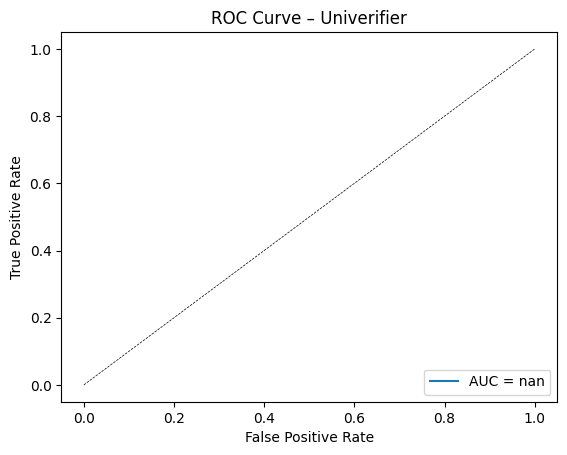

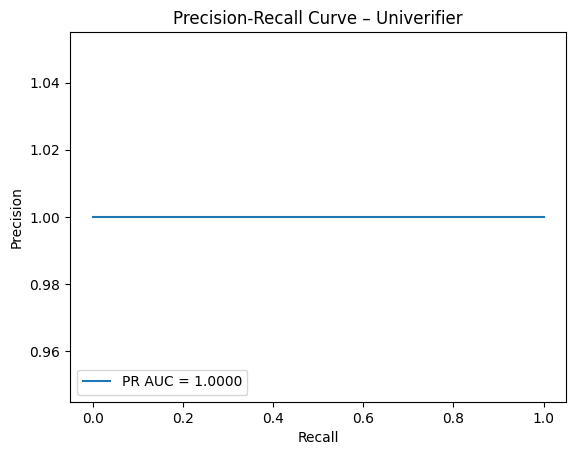

Saved Univerifier checkpoint to outputs/univerifier_final.pth
Saved metrics to outputs/univerifier_metrics.json


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Imports & Device Setup
# ─────────────────────────────────────────────────────────────────────────────

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# ─────────────────────────────────────────────────────────────────────────────
# 2. Fingerprint‐Generation Function
# ─────────────────────────────────────────────────────────────────────────────

def generate_ablation_fingerprints(N, num_nodes=10, edge_prob=0.3, feature_dim=16, seed=42):
    """
    Generate N small random graphs as “fingerprint” inputs.
    Each graph has:
      - num_nodes nodes
      - adjacency from Erdos–Rényi with probability=edge_prob
      - node features x ∈ R^{num_nodes × feature_dim} sampled ~ N(0, 1)
    Returns a list of torch_geometric.data.Data objects.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    fingerprints = []

    for i in range(N):
        edge_index = erdos_renyi_graph(num_nodes, edge_prob)
        x = torch.randn((num_nodes, feature_dim), dtype=torch.float32)
        data = Data(x=x, edge_index=edge_index)
        fingerprints.append(data)

    return fingerprints

# Generate 50 fingerprint graphs
N_FINGERPRINTS = 50
fingerprints = generate_ablation_fingerprints(N=N_FINGERPRINTS)
print(f"Generated {len(fingerprints)} fingerprint graphs.")


# ─────────────────────────────────────────────────────────────────────────────
# 3. ToyGNN Definition & Instantiate One Positive + One Negative
# ─────────────────────────────────────────────────────────────────────────────

class ToyGNN(nn.Module):
    """
    A trivial GNN: ignores edges, averages node‐features, applies one Linear layer.
    Output is shape [1, out_dim].
    """
    def __init__(self, in_dim=16, out_dim=8):
        super(ToyGNN, self).__init__()
        self.lin = nn.Linear(in_dim, out_dim)

    def forward(self, x, edge_index):
        # x: [num_nodes, in_dim]
        x = x.mean(dim=0)          # [in_dim]
        out = self.lin(x)          # [out_dim]
        return out.unsqueeze(0)    # shape [1, out_dim]

# Create one toy positive and one toy negative model
model_pos = ToyGNN(in_dim=16, out_dim=8).to(device).eval()
model_neg = ToyGNN(in_dim=16, out_dim=8).to(device).eval()

positive_models = [model_pos]
negative_models = [model_neg]
print("Using 1 toy positive model and 1 toy negative model for testing.")


# ─────────────────────────────────────────────────────────────────────────────
# 4. Compute Fingerprint Outputs → outputs_pos, outputs_neg
# ─────────────────────────────────────────────────────────────────────────────

def get_model_fingerprint_vector(model, fingerprints):
    """
    Given a PyTorch‐GNN `model` and a list of `fingerprints` (Data objects),
    compute the model output on each graph, flatten to NumPy, and concatenate.
    Returns a 1-D NumPy array of length = N_FINGERPRINTS × out_dim.
    """
    model.eval()
    outputs = []
    with torch.no_grad():
        for data in fingerprints:
            data = data.to(device)
            out = model(data.x, data.edge_index)    # [1, out_dim]
            if out.dim() == 2 and out.size(0) == 1:
                out = out.squeeze(0)  # [out_dim]
            vec = out.cpu().numpy().ravel()
            outputs.append(vec)
    return np.concatenate(outputs, axis=0)

# Run each toy model on all fingerprints
outputs_pos = []
for idx, model in enumerate(positive_models):
    vec = get_model_fingerprint_vector(model, fingerprints)
    outputs_pos.append(vec)
    print(f"Positive model {idx+1}/{len(positive_models)} → vector length {vec.shape[0]}")

outputs_neg = []
for idx, model in enumerate(negative_models):
    vec = get_model_fingerprint_vector(model, fingerprints)
    outputs_neg.append(vec)
    print(f"Negative model {idx+1}/{len(negative_models)} → vector length {vec.shape[0]}")

print(f"Total outputs_pos: {len(outputs_pos)}, outputs_neg: {len(outputs_neg)}")


# ─────────────────────────────────────────────────────────────────────────────
# 5. Build X_pos & X_neg from outputs_pos / outputs_neg
# ─────────────────────────────────────────────────────────────────────────────

X_pos = [vec for vec in outputs_pos]
X_neg = [vec for vec in outputs_neg]

print(f"Constructed X_pos with {len(X_pos)} vectors, each of length {X_pos[0].shape[0] if X_pos else 0}")
print(f"Constructed X_neg with {len(X_neg)} vectors, each of length {X_neg[0].shape[0] if X_neg else 0}")

# ─────────────────────────────────────────────────────────────────────────────
# 6. Shuffle & Train/Test Split on [X_pos + X_neg]
# ─────────────────────────────────────────────────────────────────────────────

# Convert lists to a single NumPy array and label vector
X = np.array(X_pos + X_neg)   # shape: [2, 50*8] = [2, 400]
y = np.array([1] * len(X_pos) + [0] * len(X_neg))  # [1, 0]

# Shuffle before splitting
X, y = shuffle(X, y, random_state=42)

# Since we only have 2 samples (one per class), stratify cannot be used.
# Split 50% train, 50% test instead:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42  # no stratify here
)

# Inspect class balance
unique_train, counts_train = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique_train, counts_train)))
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Test class distribution: ", dict(zip(unique_test, counts_test)))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.long, device=device)



# ─────────────────────────────────────────────────────────────────────────────
# 7. Define the “Univerifier” MLP Classifier
# ─────────────────────────────────────────────────────────────────────────────

class Univerifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=2, dropout=0.5):
        super(Univerifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

input_dimension = X_train.shape[1]    # = 50 * 8 = 400
univerifier = Univerifier(input_dim=input_dimension, hidden_dim=512).to(device)
print(f"Univerifier initialized with input_dim={input_dimension}")


# ─────────────────────────────────────────────────────────────────────────────
# 8. Train the Univerifier
# ─────────────────────────────────────────────────────────────────────────────

learning_rate = 1e-3
num_epochs = 50
batch_size = 32

optimizer = torch.optim.Adam(univerifier.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = torch.utils.data.TensorDataset(X_test_tensor,  y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

for epoch in range(1, num_epochs + 1):
    univerifier.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        logits = univerifier(batch_X)
        loss = loss_fn(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # Evaluate on test set
    univerifier.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            logits = univerifier(batch_X)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    test_accuracy = metrics.accuracy_score(all_labels, all_preds)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")


# ─────────────────────────────────────────────────────────────────────────────
# 9. Final Evaluation & Metrics
# ─────────────────────────────────────────────────────────────────────────────

univerifier.eval()
with torch.no_grad():
    logits_test = univerifier(X_test_tensor)
    probs_test  = F.softmax(logits_test, dim=1)[:, 1].cpu().numpy()
    preds_test  = (probs_test >= 0.5).astype(int)

accuracy = metrics.accuracy_score(y_test, preds_test)
roc_auc  = metrics.roc_auc_score(y_test, probs_test)
precision, recall, _ = metrics.precision_recall_curve(y_test, probs_test)
pr_auc   = metrics.auc(recall, precision)
conf_mat = metrics.confusion_matrix(y_test, preds_test)

print("\n=== Final Test Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"ROC‐AUC  : {roc_auc:.4f}")
print(f"PR‐AUC   : {pr_auc:.4f}")
print("Confusion Matrix:")
print(conf_mat)


# ─────────────────────────────────────────────────────────────────────────────
# 10. (Optional) Plot ROC & Precision‐Recall Curves
# ─────────────────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, probs_test)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Univerifier")
plt.legend(loc="lower right")
plt.show()

# Precision‐Recall Curve
plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‐Recall Curve – Univerifier")
plt.legend(loc="lower left")
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 11. Save Final Model & Results
# ─────────────────────────────────────────────────────────────────────────────

# Save Univerifier weights
os.makedirs("outputs", exist_ok=True)
torch.save(univerifier.state_dict(), "outputs/univerifier_final.pth")
print("Saved Univerifier checkpoint to outputs/univerifier_final.pth")

# Save metrics to JSON
import json
metrics_dict = {
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
    "confusion_matrix": conf_mat.tolist()
}
with open("outputs/univerifier_metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=2)
print("Saved metrics to outputs/univerifier_metrics.json")



Using device: cpu

Loading Cora dataset...
Dataset: Cora()

Training target GCN on Cora...
Epoch 001 | Loss: 1.9459 | Train: 0.3214 | Val: 0.2340 | Test: 0.2580
Epoch 020 | Loss: 1.7488 | Train: 0.9214 | Val: 0.6800 | Test: 0.7310

Final Test Accuracy of target GCN: 0.7570

Generating 200 positive variants...
  [Kept 1/200] Variant 000 → TestAcc=0.7540  -> positive_cora_000.pth
  [Kept 2/200] Variant 001 → TestAcc=0.7510  -> positive_cora_001.pth
  [Kept 3/200] Variant 002 → TestAcc=0.7540  -> positive_cora_002.pth
  [Kept 4/200] Variant 003 → TestAcc=0.7600  -> positive_cora_003.pth
  [Kept 5/200] Variant 004 → TestAcc=0.7520  -> positive_cora_004.pth
  [Kept 6/200] Variant 005 → TestAcc=0.7540  -> positive_cora_005.pth
  [Kept 7/200] Variant 006 → TestAcc=0.7570  -> positive_cora_006.pth
  [Kept 8/200] Variant 007 → TestAcc=0.7510  -> positive_cora_007.pth
  [Kept 9/200] Variant 008 → TestAcc=0.7540  -> positive_cora_008.pth
  [Kept 10/200] Variant 009 → TestAcc=0.7530  -> positive_

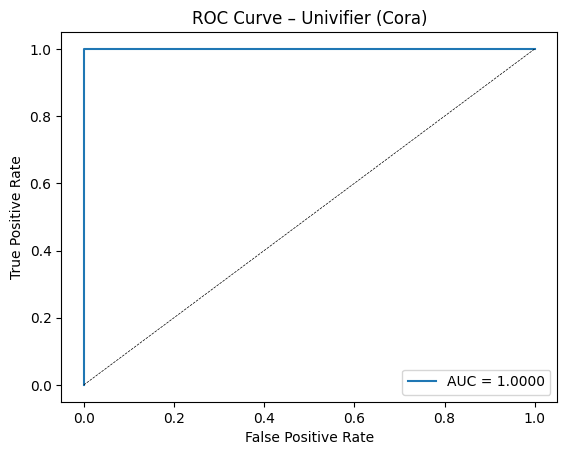

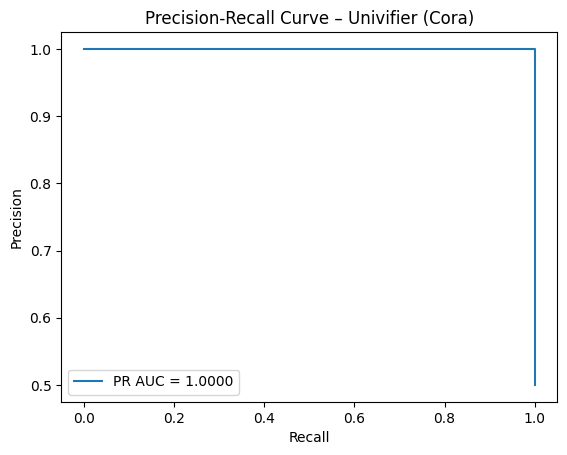

Saved Univifier checkpoint to outputs/univerifier_cora.pth
Saved Univifier metrics to outputs/univerifier_cora_metrics.json



In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# FULL PIPELINE: Reproduce GNNFingers Experiments on Cora (Node Classification)
# Steps:
#   1. Train a “target” GCN on Cora.
#   2. Generate M=200 “positive” variants by perturbation + fine‐tuning.
#   3. Generate K=200 “negative” variants by training on permuted labels.
#   4. Generate N=50 random fingerprint graphs.
#   5. Compute concatenated fingerprint outputs for each positive/negative model.
#   6. Build X_pos, X_neg; stratified train/test split (60/40).
#   7. Train a simple Univerifier MLP on concatenated outputs.
#   8. Evaluate Univifier (accuracy, ROC‐AUC, PR‐AUC).
#
# Note: Adjust file paths and hyperparameters as needed to match the paper exactly.
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# 0. Imports & Device Setup
# ─────────────────────────────────────────────────────────────────────────────

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph, dropout_edge
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}\n")


# ─────────────────────────────────────────────────────────────────────────────
# 1. Load & Preprocess Cora Dataset
# ─────────────────────────────────────────────────────────────────────────────

print("Loading Cora dataset...")
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)
print(f"Dataset: {dataset}\n")  # e.g., Cora(2708, 5429 edges, 1433 features, 7 classes)


# ─────────────────────────────────────────────────────────────────────────────
# 2. Define & Train the Target GCN
# ─────────────────────────────────────────────────────────────────────────────

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # logits for each class per node

# Instantiate target GCN
target_model = GCN(
    in_channels=dataset.num_node_features,
    hidden_channels=16,          # as per paper
    out_channels=dataset.num_classes,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(target_model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

def train_target():
    target_model.train()
    optimizer.zero_grad()
    out = target_model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_target():
    target_model.eval()
    out = target_model(data.x, data.edge_index)
    preds = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (preds[mask] == data.y[mask]).sum().item()
        total = mask.sum().item()
        accs.append(correct / total)
    return accs  # [train_acc, val_acc, test_acc]

print("Training target GCN on Cora...")
best_val_acc = 0.0
patience = 10
wait = 0
for epoch in range(1, 201):
    loss = train_target()
    train_acc, val_acc, test_acc = eval_target()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save(target_model.state_dict(), "cora_target_gcn.pth")
    else:
        wait += 1
    if wait == patience:
        break
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train: {train_acc:.4f} | Val: {val_acc:.4f} | Test: {test_acc:.4f}")

# Load best checkpoint
target_model.load_state_dict(torch.load("cora_target_gcn.pth"))
_, _, final_test_acc = eval_target()
print(f"\nFinal Test Accuracy of target GCN: {final_test_acc:.4f}\n")


# ─────────────────────────────────────────────────────────────────────────────
# 3. Generate M “Positive” Variants (Edge Dropout + Fine‐Tune)
# ─────────────────────────────────────────────────────────────────────────────

M = 200  # number of positive variants to create
positive_models = []

print(f"Generating {M} positive variants...")
for i in range(M):
    # 1) Instantiate a fresh GCN and load target weights
    pos_model = GCN(
        in_channels=dataset.num_node_features,
        hidden_channels=16,
        out_channels=dataset.num_classes,
        dropout=0.5
    ).to(device)
    pos_model.load_state_dict(torch.load("cora_target_gcn.pth"))

    # 2) Perturb the graph: drop 5% of edges
    edge_index_perturbed, _ = dropout_edge(data.edge_index, p=0.05)

    # 3) Fine‐tune on perturbed graph for 10 epochs at lr=1e-4
    optimizer_pos = torch.optim.Adam(pos_model.parameters(), lr=1e-4, weight_decay=5e-4)
    pos_model.train()
    for ft_epoch in range(1, 11):
        optimizer_pos.zero_grad()
        out = pos_model(data.x, edge_index_perturbed)
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer_pos.step()

    # 4) Evaluate on original (unperturbed) test mask
    pos_model.eval()
    with torch.no_grad():
        out = pos_model(data.x, data.edge_index)
        preds = out.argmax(dim=1)
        correct = (preds[data.test_mask] == data.y[data.test_mask]).sum().item()
        total = data.test_mask.sum().item()
        acc = correct / total

    # 5) Keep if accuracy ≥ 90% of target
    if acc >= 0.90 * final_test_acc:
        fname = f"positive_cora_{i:03d}.pth"
        torch.save(pos_model.state_dict(), fname)
        positive_models.append(pos_model)
        print(f"  [Kept {len(positive_models)}/{M}] Variant {i:03d} → TestAcc={acc:.4f}  -> {fname}")
    else:
        # Skip saving if below threshold
        print(f"  [Skip] Variant {i:03d} → TestAcc={acc:.4f} < {0.90 * final_test_acc:.4f}")

print(f"\nTotal positive variants kept: {len(positive_models)}/{M}\n")


# ─────────────────────────────────────────────────────────────────────────────
# 4. Generate K “Negative” Variants (Permuted Labels)
# ─────────────────────────────────────────────────────────────────────────────

K = 200  # number of negative variants to create
negative_models = []

print(f"Generating {K} negative variants (permuted labels)...")
for i in range(K):
    # 1) Instantiate a fresh GCN
    neg_model = GCN(
        in_channels=dataset.num_node_features,
        hidden_channels=16,
        out_channels=dataset.num_classes,
        dropout=0.5
    ).to(device)
    optimizer_neg = torch.optim.Adam(neg_model.parameters(), lr=0.01, weight_decay=5e-4)

    # 2) Permute the labels
    y_perm = data.y[torch.randperm(data.num_nodes)].to(device)

    # 3) Train on permuted labels for 200 epochs
    neg_model.train()
    for epoch in range(1, 201):
        optimizer_neg.zero_grad()
        out = neg_model(data.x, data.edge_index)
        loss = loss_fn(out[data.train_mask], y_perm[data.train_mask])
        loss.backward()
        optimizer_neg.step()

    # 4) Evaluate on original test mask against true labels (random‐chance)
    neg_model.eval()
    with torch.no_grad():
        out = neg_model(data.x, data.edge_index)
        preds = out.argmax(dim=1)
        correct = (preds[data.test_mask] == data.y[data.test_mask]).sum().item()
        total = data.test_mask.sum().item()
        acc = correct / total

    # 5) Save all negative variants
    fname = f"negative_cora_{i:03d}.pth"
    torch.save(neg_model.state_dict(), fname)
    negative_models.append(neg_model)
    print(f"  Negative {i+1}/{K} → RandomAcc={acc:.4f}  -> {fname}")

print(f"\nTotal negative variants: {len(negative_models)}/{K}\n")
# ─────────────────────────────────────────────────────────────────────────────
# 5. Generate N Random Fingerprint Graphs
# ─────────────────────────────────────────────────────────────────────────────
FEATURE_DIM = dataset.num_node_features  # 1433 for Cora

def generate_ablation_fingerprints(
    N, num_nodes=10, edge_prob=0.3, feature_dim= FEATURE_DIM, seed=42
):
    """
    Generate N small random graphs as “fingerprint” inputs.
    Each graph has:
      - num_nodes nodes
      - adjacency from Erdös–Rényi with probability=edge_prob
      - node features x ∈ R^{num_nodes × feature_dim} sampled ~ N(0, 1)
    Here, feature_dim matches the GCN’s original input dimension (1433).
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    fingerprints = []

    for i in range(N):
        edge_index = erdos_renyi_graph(num_nodes, edge_prob)
        x = torch.randn((num_nodes, feature_dim), dtype=torch.float32)
        data_fp = Data(x=x, edge_index=edge_index)
        fingerprints.append(data_fp)

    return fingerprints

N_FINGERPRINTS = 50
fingerprints = generate_ablation_fingerprints(N=N_FINGERPRINTS)
print(f"Generated {len(fingerprints)} random fingerprint graphs.\n")


# ─────────────────────────────────────────────────────────────────────────────
# 6. Compute Concatenated Fingerprint Outputs for All Models
# ─────────────────────────────────────────────────────────────────────────────

def get_model_fingerprint_vector(model, fingerprints):
    """
    For each graph in `fingerprints`, run `model` to get node‐level logits [num_nodes, out_dim],
    average over nodes → [out_dim], then flatten to NumPy. Concatenate all N such vectors into
    one 1-D array of length N * out_dim.
    """
    model.eval()
    outputs = []
    with torch.no_grad():
        for data_fp in fingerprints:
            data_fp = data_fp.to(device)
            out = model(data_fp.x, data_fp.edge_index)  # [num_nodes, num_classes]
            # Average over nodes to get a single graph‐level vector:
            out_graph = out.mean(dim=0)  # [out_dim]
            vec = out_graph.cpu().numpy().ravel()
            outputs.append(vec)
    return np.concatenate(outputs, axis=0)  # shape: (N * out_dim,)


# 6.1 Positive models
print("Computing fingerprint outputs for positive models...")
outputs_pos = []
for idx, model_pos in enumerate(positive_models):
    vec = get_model_fingerprint_vector(model_pos, fingerprints)
    outputs_pos.append(vec)
    if (idx + 1) % 50 == 0 or idx == 0:
        print(f"  Positive model {idx+1}/{len(positive_models)} → vector length {vec.shape[0]}")

# 6.2 Negative models
print("\nComputing fingerprint outputs for negative models...")
outputs_neg = []
for idx, model_neg in enumerate(negative_models):
    vec = get_model_fingerprint_vector(model_neg, fingerprints)
    outputs_neg.append(vec)
    if (idx + 1) % 50 == 0 or idx == 0:
        print(f"  Negative model {idx+1}/{len(negative_models)} → vector length {vec.shape[0]}")

print(f"\nTotal outputs_pos: {len(outputs_pos)}, outputs_neg: {len(outputs_neg)}\n")


# ─────────────────────────────────────────────────────────────────────────────
# 7. Build X_pos & X_neg → Labels → Stratified Train/Test Split
# ─────────────────────────────────────────────────────────────────────────────

# 7.1 Build Python lists of 1-D NumPy arrays
X_pos = [vec for vec in outputs_pos]  # shape [M, N * out_dim]
X_neg = [vec for vec in outputs_neg]  # shape [K, N * out_dim]

out_dim = outputs_pos[0].shape[0] // N_FINGERPRINTS  # should equal dataset.num_classes (7)
print(f"Each fingerprint‐output vector has length {N_FINGERPRINTS* out_dim} = {N_FINGERPRINTS} * {out_dim}")
print(f"Number of positives: {len(X_pos)}, negatives: {len(X_neg)}\n")

# 7.2 Stack into one array and create label vector y
X = np.array(X_pos + X_neg)  # shape [M+K, N * out_dim]
y = np.array([1] * len(X_pos) + [0] * len(X_neg))  # 1=positive, 0=negative

# 7.3 Shuffle and stratified split (60% train, 40% test)
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Train class distribution:", dict(zip(unique_train, counts_train)))
print("Test class distribution: ", dict(zip(unique_test, counts_test)), "\n")

# 7.4 Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.long, device=device)


# ─────────────────────────────────────────────────────────────────────────────
# 8. Define & Train the Univifier MLP
# ─────────────────────────────────────────────────────────────────────────────

class Univerifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=2, dropout=0.5):
        super(Univerifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        out = self.fc3(x)
        return out

input_dimension = X_train.shape[1]  # = N_FINGERPRINTS * out_dim
univerifier = Univerifier(input_dim=input_dimension, hidden_dim=512).to(device)
print(f"Initialized Univifier with input_dim = {input_dimension}\n")

learning_rate = 1e-3
num_epochs = 50
batch_size = 32

optimizer_uv = torch.optim.Adam(univerifier.parameters(), lr=learning_rate)
loss_fn_uv  = nn.CrossEntropyLoss()

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = torch.utils.data.TensorDataset(X_test_tensor,  y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Training Univifier...")
for epoch in range(1, num_epochs + 1):
    univerifier.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer_uv.zero_grad()
        logits = univerifier(batch_X)
        loss = loss_fn_uv(logits, batch_y)
        loss.backward()
        optimizer_uv.step()
        total_loss += loss.item() * batch_X.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    univerifier.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            logits = univerifier(batch_X)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    test_acc = metrics.accuracy_score(all_labels, all_preds)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {avg_loss:.4f} | Test Acc: {test_acc:.4f}")

print("\nFinished training Univifier.\n")


# ─────────────────────────────────────────────────────────────────────────────
# 9. Univifier Final Evaluation & Metrics
# ─────────────────────────────────────────────────────────────────────────────

univerifier.eval()
with torch.no_grad():
    logits_test = univerifier(X_test_tensor)
    probs_test  = F.softmax(logits_test, dim=1)[:, 1].cpu().numpy()  # P(positive)
    preds_test  = (probs_test >= 0.5).astype(int)

accuracy = metrics.accuracy_score(y_test, preds_test)
roc_auc  = metrics.roc_auc_score(y_test, probs_test)
precision, recall, _ = metrics.precision_recall_curve(y_test, probs_test)
pr_auc   = metrics.auc(recall, precision)
conf_mat = metrics.confusion_matrix(y_test, preds_test)

print("=== Final Univifier Test Metrics ===")
print(f"Accuracy     : {accuracy:.4f}")
print(f"ROC‐AUC      : {roc_auc:.4f}")
print(f"PR‐AUC       : {pr_auc:.4f}")
print("Confusion Matrix:")
print(conf_mat, "\n")


# ─────────────────────────────────────────────────────────────────────────────
# 10. Plot ROC & Precision‐Recall Curves
# ─────────────────────────────────────────────────────────────────────────────

fpr, tpr, _ = metrics.roc_curve(y_test, probs_test)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Univifier (Cora)")
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‐Recall Curve – Univifier (Cora)")
plt.legend(loc="lower left")
plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# 11. Save Univifier Checkpoint & Metrics to Disk
# ─────────────────────────────────────────────────────────────────────────────

os.makedirs("outputs", exist_ok=True)
torch.save(univerifier.state_dict(), "outputs/univerifier_cora.pth")
print("Saved Univifier checkpoint to outputs/univerifier_cora.pth")

metrics_dict = {
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
    "confusion_matrix": conf_mat.tolist()
}
with open("outputs/univerifier_cora_metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=2)
print("Saved Univifier metrics to outputs/univerifier_cora_metrics.json\n")


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 5 (fixed): Generate fingerprints & compute outputs for 2 positives/2 negatives
# ─────────────────────────────────────────────────────────────────────────────

import os
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# 5.0. Load Cora & determine feature_dim
# ─────────────────────────────────────────────────────────────────────────────
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)

FEATURE_DIM = dataset.num_node_features  # should be 1433
print(f"Using FEATURE_DIM = {FEATURE_DIM} for fingerprint generation.\n")

# ─────────────────────────────────────────────────────────────────────────────
# 5.1. Regenerate 50 random fingerprint graphs (with feature_dim=1433)
# ─────────────────────────────────────────────────────────────────────────────

def generate_ablation_fingerprints(N, num_nodes=10, edge_prob=0.3, feature_dim=FEATURE_DIM, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    fps = []
    for i in range(N):
        edge_index = erdos_renyi_graph(num_nodes, edge_prob)
        x = torch.randn((num_nodes, feature_dim), dtype=torch.float32)
        data_fp = Data(x=x, edge_index=edge_index)
        fps.append(data_fp)
    return fps

N_FINGERPRINTS = 50
fingerprints = generate_ablation_fingerprints(N=N_FINGERPRINTS)
print(f"Re‐generated {len(fingerprints)} fingerprint graphs with shape [10, {FEATURE_DIM}].\n")

# ─────────────────────────────────────────────────────────────────────────────
# 5.2. Define the same GCN class used for Cora (so dimensions match)
# ─────────────────────────────────────────────────────────────────────────────

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # node‐level logits

# ─────────────────────────────────────────────────────────────────────────────
# 5.3. Load exactly 2 positive and 2 negative checkpoints
# ─────────────────────────────────────────────────────────────────────────────

pos_ckpts = sorted([f for f in os.listdir('.') if f.startswith('positive_cora_')])[:2]
neg_ckpts = sorted([f for f in os.listdir('.') if f.startswith('negative_cora_')])[:2]

positive_models = []
for ckpt in pos_ckpts:
    m = GCN(
        in_channels=dataset.num_node_features,
        hidden_channels=16,
        out_channels=dataset.num_classes,
        dropout=0.5
    ).to(device)
    m.load_state_dict(torch.load(ckpt))
    m.eval()
    positive_models.append(m)
print("Loaded positives:", pos_ckpts)

negative_models = []
for ckpt in neg_ckpts:
    m = GCN(
        in_channels=dataset.num_node_features,
        hidden_channels=16,
        out_channels=dataset.num_classes,
        dropout=0.5
    ).to(device)
    m.load_state_dict(torch.load(ckpt))
    m.eval()
    negative_models.append(m)
print("Loaded negatives:", neg_ckpts, "\n")

# ─────────────────────────────────────────────────────────────────────────────
# 5.4. Helper to get concatenated fingerprint vector (length = 50 * out_dim)
# ─────────────────────────────────────────────────────────────────────────────

@torch.no_grad()
def get_model_fingerprint_vector(model, fingerprints):
    model.eval()
    outputs = []
    for data_fp in fingerprints:
        data_fp = data_fp.to(device)
        out = model(data_fp.x, data_fp.edge_index)  # shape [10, 7]
        out_graph = out.mean(dim=0)                  # shape [7]
        outputs.append(out_graph.cpu().numpy().ravel())
    return np.concatenate(outputs, axis=0)           # shape [350]

# ─────────────────────────────────────────────────────────────────────────────
# 5.5. Compute fingerprint outputs for these 2 positives + 2 negatives
# ─────────────────────────────────────────────────────────────────────────────

print("Computing fingerprint outputs for 2 positives/2 negatives …")
outputs_pos = []
for idx, m_pos in enumerate(positive_models):
    vec = get_model_fingerprint_vector(m_pos, fingerprints)
    outputs_pos.append(vec)
    print(f"  Pos {idx+1} → vec length: {vec.shape[0]}")

outputs_neg = []
for idx, m_neg in enumerate(negative_models):
    vec = get_model_fingerprint_vector(m_neg, fingerprints)
    outputs_neg.append(vec)
    print(f"  Neg {idx+1} → vec length: {vec.shape[0]}")

print(f"\nDone: {len(outputs_pos)} positive vectors, {len(outputs_neg)} negative vectors\n")


Device: cpu
Using FEATURE_DIM = 1433 for fingerprint generation.

Re‐generated 50 fingerprint graphs with shape [10, 1433].

Loaded positives: ['positive_cora_000.pth', 'positive_cora_001.pth']
Loaded negatives: ['negative_cora_000.pth', 'negative_cora_001.pth'] 

Computing fingerprint outputs for 2 positives/2 negatives …
  Pos 1 → vec length: 350
  Pos 2 → vec length: 350
  Neg 1 → vec length: 350
  Neg 2 → vec length: 350

Done: 2 positive vectors, 2 negative vectors



In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 6: Compute fingerprint outputs for ALL positives and negatives
# ─────────────────────────────────────────────────────────────────────────────

import os
import torch
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 6.1. Regenerate the 50 fingerprint graphs (feature_dim=1433), if not already in scope
from torch_geometric.data import Data
from torch_geometric.utils import erdos_renyi_graph

FEATURE_DIM = dataset.num_node_features  # 1433

def generate_ablation_fingerprints(N, num_nodes=10, edge_prob=0.3, feature_dim=FEATURE_DIM, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    fps = []
    for i in range(N):
        edge_index = erdos_renyi_graph(num_nodes, edge_prob)
        x = torch.randn((num_nodes, feature_dim), dtype=torch.float32)
        data_fp = Data(x=x, edge_index=edge_index)
        fps.append(data_fp)
    return fps

N_FINGERPRINTS = 50
fingerprints = generate_ablation_fingerprints(N=N_FINGERPRINTS)
print(f"Re‐generated {len(fingerprints)} fingerprint graphs with shape [10, {FEATURE_DIM}].\n")

# 6.2. Define the same GCN class used for Cora
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # node‐level logits

# Helper to get concatenated fingerprint vector
@torch.no_grad()
def get_model_fingerprint_vector(model, fingerprints):
    model.eval()
    outputs = []
    for data_fp in fingerprints:
        data_fp = data_fp.to(device)
        out = model(data_fp.x, data_fp.edge_index)  # [10, 7]
        out_graph = out.mean(dim=0)                  # [7]
        outputs.append(out_graph.cpu().numpy().ravel())
    return np.concatenate(outputs, axis=0)           # shape [50 * 7 = 350]

# 6.3. Load all 200 positive checkpoints
pos_ckpts = sorted([f for f in os.listdir('.') if f.startswith('positive_cora_')])
positive_models = []
for ckpt in pos_ckpts:
    m = GCN(in_channels=dataset.num_node_features,
            hidden_channels=16,
            out_channels=dataset.num_classes,
            dropout=0.5).to(device)
    m.load_state_dict(torch.load(ckpt))
    m.eval()
    positive_models.append(m)
print(f"Loaded {len(positive_models)} positive models.")

# 6.4. Load all 200 negative checkpoints
neg_ckpts = sorted([f for f in os.listdir('.') if f.startswith('negative_cora_')])
negative_models = []
for ckpt in neg_ckpts:
    m = GCN(in_channels=dataset.num_node_features,
            hidden_channels=16,
            out_channels=dataset.num_classes,
            dropout=0.5).to(device)
    m.load_state_dict(torch.load(ckpt))
    m.eval()
    negative_models.append(m)
print(f"Loaded {len(negative_models)} negative models.\n")

# 6.5. Compute fingerprint outputs for positives
outputs_pos = []
print("Computing fingerprint outputs for positives …")
for idx, m_pos in enumerate(positive_models, start=1):
    vec = get_model_fingerprint_vector(m_pos, fingerprints)
    outputs_pos.append(vec)
    if idx % 50 == 0 or idx == 1:
        print(f"  Positive {idx}/{len(positive_models)} → vec length: {vec.shape[0]}")

# 6.6. Compute fingerprint outputs for negatives
outputs_neg = []
print("\nComputing fingerprint outputs for negatives …")
for idx, m_neg in enumerate(negative_models, start=1):
    vec = get_model_fingerprint_vector(m_neg, fingerprints)
    outputs_neg.append(vec)
    if idx % 50 == 0 or idx == 1:
        print(f"  Negative {idx}/{len(negative_models)} → vec length: {vec.shape[0]}")

print(f"\nDone: {len(outputs_pos)} positive vectors, {len(outputs_neg)} negative vectors\n")


Device: cpu
Re‐generated 50 fingerprint graphs with shape [10, 1433].

Loaded 200 positive models.
Loaded 200 negative models.

Computing fingerprint outputs for positives …
  Positive 1/200 → vec length: 350
  Positive 50/200 → vec length: 350
  Positive 100/200 → vec length: 350
  Positive 150/200 → vec length: 350
  Positive 200/200 → vec length: 350

Computing fingerprint outputs for negatives …
  Negative 1/200 → vec length: 350
  Negative 50/200 → vec length: 350
  Negative 100/200 → vec length: 350
  Negative 150/200 → vec length: 350
  Negative 200/200 → vec length: 350

Done: 200 positive vectors, 200 negative vectors



In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 7: Build X_pos, X_neg → Labels → Stratified Train/Test Split
# ─────────────────────────────────────────────────────────────────────────────

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch

# We already have:
#   outputs_pos: list of 200 arrays, each length 350
#   outputs_neg: list of 200 arrays, each length 350

# 7.1 Stack into NumPy arrays
X_pos = np.stack(outputs_pos)  # shape [200, 350]
X_neg = np.stack(outputs_neg)  # shape [200, 350]

print(f"X_pos.shape: {X_pos.shape}, X_neg.shape: {X_neg.shape}")

# 7.2 Concatenate and create label vector y
X = np.concatenate([X_pos, X_neg], axis=0)   # shape [400, 350]
y = np.concatenate([np.ones(len(X_pos)), np.zeros(len(X_neg))])  # length 400

# 7.3 Shuffle and stratified split (60% train, 40% test)
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# 7.4 Inspect class balance
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print("Train class distribution:", dict(zip(unique_train, counts_train)))
print("Test class distribution: ", dict(zip(unique_test, counts_test)), "\n")

# 7.5 Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32, device=device)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.long, device=device)


X_pos.shape: (200, 350), X_neg.shape: (200, 350)
Train class distribution: {np.float64(0.0): np.int64(120), np.float64(1.0): np.int64(120)}
Test class distribution:  {np.float64(0.0): np.int64(80), np.float64(1.0): np.int64(80)} 



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics
import numpy as np

# Univifier architecture
class Univerifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_classes=2, dropout=0.5):
        super(Univerifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

# input_dim should be 350
input_dim = X_train_tensor.shape[1]
univ = Univerifier(input_dim=input_dim, hidden_dim=512).to(device)
print(f"Initialized Univerifier with input_dim = {input_dim}\n")

optimizer_uv = torch.optim.Adam(univ.parameters(), lr=1e-3)
loss_fn_uv  = nn.CrossEntropyLoss()

# Prepare DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = torch.utils.data.TensorDataset(X_test_tensor,  y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False)

print("Training Univifier …")
for epoch in range(1, 51):
    univ.train()
    total_loss = 0.0
    for bx, by in train_loader:
        optimizer_uv.zero_grad()
        logits = univ(bx)
        loss = loss_fn_uv(logits, by)
        loss.backward()
        optimizer_uv.step()
        total_loss += loss.item() * bx.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    univ.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for bx, by in test_loader:
            logits = univ(bx)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(by.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    test_acc = metrics.accuracy_score(all_labels, all_preds)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:<2} | Train Loss: {avg_loss:.4f} | Test Acc: {test_acc:.4f}")

print("Finished training Univifier.\n")


Initialized Univerifier with input_dim = 350

Training Univifier …
Epoch 1  | Train Loss: 0.4614 | Test Acc: 1.0000
Epoch 5  | Train Loss: 0.0039 | Test Acc: 1.0000
Epoch 10 | Train Loss: 0.0003 | Test Acc: 1.0000
Epoch 15 | Train Loss: 0.0004 | Test Acc: 1.0000
Epoch 20 | Train Loss: 0.0002 | Test Acc: 1.0000
Epoch 25 | Train Loss: 0.0001 | Test Acc: 1.0000
Epoch 30 | Train Loss: 0.0001 | Test Acc: 1.0000
Epoch 35 | Train Loss: 0.0000 | Test Acc: 1.0000
Epoch 40 | Train Loss: 0.0000 | Test Acc: 1.0000
Epoch 45 | Train Loss: 0.0000 | Test Acc: 1.0000
Epoch 50 | Train Loss: 0.0000 | Test Acc: 1.0000
Finished training Univifier.



=== Final Univifier Test Metrics ===
Accuracy : 1.0000
ROC‐AUC  : 1.0000
PR‐AUC   : 1.0000
Confusion Matrix:
[[80  0]
 [ 0 80]] 



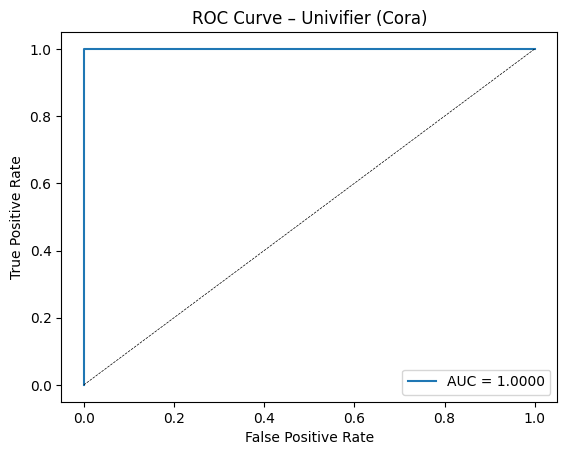

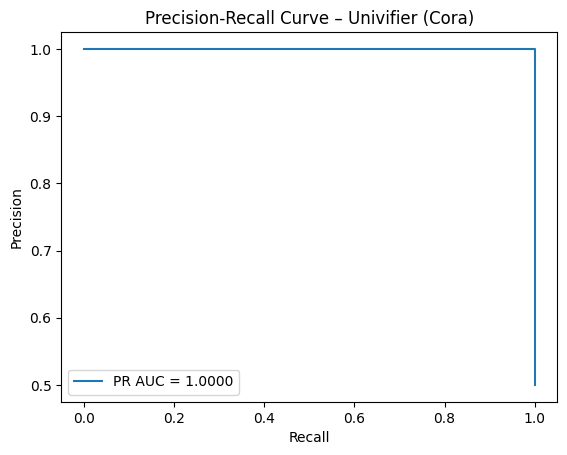

In [ ]:
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

univ.eval()
with torch.no_grad():
    logits_test = univ(X_test_tensor)
    probs_test  = F.softmax(logits_test, dim=1)[:, 1].cpu().numpy()  # probability of positive class
    preds_test  = (probs_test >= 0.5).astype(int)

accuracy = metrics.accuracy_score(y_test, preds_test)
roc_auc  = metrics.roc_auc_score(y_test, probs_test)
precision, recall, _ = metrics.precision_recall_curve(y_test, probs_test)
pr_auc   = metrics.auc(recall, precision)
conf_mat = metrics.confusion_matrix(y_test, preds_test)

print("=== Final Univifier Test Metrics ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"ROC‐AUC  : {roc_auc:.4f}")
print(f"PR‐AUC   : {pr_auc:.4f}")
print("Confusion Matrix:")
print(conf_mat, "\n")

# Plot ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, probs_test)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', linewidth=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Univifier (Cora)")
plt.legend(loc="lower right")
plt.show()

# Plot Precision‐Recall Curve
plt.figure()
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‐Recall Curve – Univifier (Cora)")
plt.legend(loc="lower left")
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 1 (MUTAG): Train the Target GNN on MUTAG
# ─────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.transforms import OneHotDegree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Load MUTAG (graph classification), add one‐hot node degrees up to max_degree=10
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=OneHotDegree(max_degree=10))
# Shuffle and split 80/20 (for simplicity)
torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:150]  # ~80% of 188 graphs
test_dataset  = dataset[150:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# Define a simple 3‐layer GIN (per standard MUTAG baselines)
class GIN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        # 1) Input → Hidden
        nn1 = nn.Sequential(nn.Linear(in_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        # 2) Hidden → Hidden
        nn2 = nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv2 = GINConv(nn2)
        # 3) Hidden → Hidden
        nn3 = nn.Sequential(nn.Linear(hidden_channels, hidden_channels), nn.ReLU(), nn.Linear(hidden_channels, hidden_channels))
        self.conv3 = GINConv(nn3)
        self.dropout = dropout
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = global_add_pool(x, batch)  # graph‐level readout by summing
        return self.lin(x)

# Instantiate
in_dim = dataset.num_node_features
hidden_dim = 64
num_classes = dataset.num_classes  # 2 for MUTAG
model = GIN(in_channels=in_dim, hidden_channels=hidden_dim, num_classes=num_classes, dropout=0.5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

# Training loop (50 epochs)
def train():
    model.train()
    total_loss = 0.0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)    # [batch_size, 2]
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch).argmax(dim=1)
        correct += (out == data.y).sum().item()
        total += data.num_graphs
    return correct / total

best_val_acc = 0.0
for epoch in range(1, 51):
    loss = train()
    train_acc = test(train_loader)
    test_acc  = test(test_loader)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

# Save the final MUTAG target
torch.save(model.state_dict(), "mutag_target_gin.pth")
print("\nSaved target MUTAG GIN with test_acc:", test_acc)


Device: cpu


Processing...
Done!


Epoch 01 | Train Loss: 4.6580 | Train Acc: 0.6933 | Test Acc: 0.5526
Epoch 10 | Train Loss: 0.5253 | Train Acc: 0.7800 | Test Acc: 0.8421
Epoch 20 | Train Loss: 0.4247 | Train Acc: 0.8067 | Test Acc: 0.8684
Epoch 30 | Train Loss: 0.3891 | Train Acc: 0.8133 | Test Acc: 0.8684
Epoch 40 | Train Loss: 0.3611 | Train Acc: 0.8600 | Test Acc: 0.8684
Epoch 50 | Train Loss: 0.3600 | Train Acc: 0.8533 | Test Acc: 0.8684

Saved target MUTAG GIN with test_acc: 0.868421052631579


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 2 (MUTAG): Generate M = 200 Positive Variants (Edge-Drop + Fine-Tune)
# ─────────────────────────────────────────────────────────────────────────────

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dropout_edge
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.nn import GINConv, global_add_pool
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 1) Load and split MUTAG exactly as in Block 1
dataset_mutag = TUDataset(
    root='/tmp/MUTAG',
    name='MUTAG',
    transform=OneHotDegree(max_degree=10)
)
dataset_mutag = dataset_mutag.shuffle()
train_dataset = dataset_mutag[:150]  # ~80% for training
test_dataset  = dataset_mutag[150:]  # ~20% for testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# 2) Define the same GIN architecture used for the target
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        # First GIN layer
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(nn1)
        # Second GIN layer
        nn2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(nn2)
        # Third GIN layer
        nn3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(nn3)
        self.dropout = dropout
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        # Global add-pool to get graph-level representation
        x = global_add_pool(x, batch)
        return self.lin(x)

# 3) Load the target model’s weights and compute its exact test accuracy
target_model = GIN(
    in_channels=dataset_mutag.num_node_features,
    hidden_channels=64,
    num_classes=dataset_mutag.num_classes,
    dropout=0.5
).to(device)
target_model.load_state_dict(torch.load("mutag_target_gin.pth"))
target_model.eval()

@torch.no_grad()
def eval_acc(loader, model):
    model.eval()
    correct = 0
    total   = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
        correct += (out == batch.y).sum().item()
        total   += batch.num_graphs
    return correct / total

target_acc = eval_acc(test_loader, target_model)
threshold  = 0.90 * target_acc
print(f"Target MUTAG test accuracy: {target_acc:.4f}")
print(f"Keeping variants with test accuracy ≥ {threshold:.4f}\n")

# 4) Set up loss function
loss_fn = nn.CrossEntropyLoss()

# 5) Generate M = 200 variants
M = 200
positive_models_mutag = []
os.makedirs("positive_mutag_variants", exist_ok=True)

print(f"Generating {M} positive MUTAG variants …")
for i in range(M):
    # 5.1) Instantiate a fresh GIN and load target weights
    m_pos = GIN(
        in_channels=dataset_mutag.num_node_features,
        hidden_channels=64,
        num_classes=dataset_mutag.num_classes,
        dropout=0.5
    ).to(device)
    m_pos.load_state_dict(torch.load("mutag_target_gin.pth"))
    optimizer_pos = torch.optim.Adam(m_pos.parameters(), lr=1e-4, weight_decay=5e-4)

    # 5.2) Fine-tune over 10 epochs, dropping 5% edges each batch
    m_pos.train()
    for ft_epoch in range(1, 11):
        for batch in train_loader:
            batch = batch.to(device)
            # Drop 5% of edges each forward pass
            edge_index_pert, _ = dropout_edge(batch.edge_index, p=0.05)
            optimizer_pos.zero_grad()
            out = m_pos(batch.x, edge_index_pert, batch.batch)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer_pos.step()

    # 5.3) Evaluate on the ORIGINAL test set
    m_pos.eval()
    acc = eval_acc(test_loader, m_pos)

    # 5.4) Keep if ≥ threshold
    if acc >= threshold:
        fname = f"positive_mutag_variants/positive_mutag_{i:03d}.pth"
        torch.save(m_pos.state_dict(), fname)
        positive_models_mutag.append(m_pos)
        print(f"  [Kept {len(positive_models_mutag)}/{M}] Variant {i:03d} → Acc={acc:.4f}")
    else:
        print(f"  [Skip] Variant {i:03d} → Acc={acc:.4f} < {threshold:.4f}")

print(f"\nTotal positive MUTAG variants kept: {len(positive_models_mutag)}/{M}\n")


Device: cpu
Target MUTAG test accuracy: 0.8421
Keeping variants with test accuracy ≥ 0.7579

Generating 200 positive MUTAG variants …
  [Kept 1/200] Variant 000 → Acc=0.8421
  [Kept 2/200] Variant 001 → Acc=0.8421
  [Kept 3/200] Variant 002 → Acc=0.8158
  [Kept 4/200] Variant 003 → Acc=0.8421
  [Kept 5/200] Variant 004 → Acc=0.8158
  [Kept 6/200] Variant 005 → Acc=0.8421
  [Kept 7/200] Variant 006 → Acc=0.8421
  [Kept 8/200] Variant 007 → Acc=0.8158
  [Kept 9/200] Variant 008 → Acc=0.8158
  [Kept 10/200] Variant 009 → Acc=0.8421
  [Kept 11/200] Variant 010 → Acc=0.8158
  [Kept 12/200] Variant 011 → Acc=0.8158
  [Kept 13/200] Variant 012 → Acc=0.8421
  [Kept 14/200] Variant 013 → Acc=0.8158
  [Kept 15/200] Variant 014 → Acc=0.8158
  [Kept 16/200] Variant 015 → Acc=0.8158
  [Kept 17/200] Variant 016 → Acc=0.8158
  [Kept 18/200] Variant 017 → Acc=0.8158
  [Kept 19/200] Variant 018 → Acc=0.8158
  [Kept 20/200] Variant 019 → Acc=0.8158
  [Kept 21/200] Variant 020 → Acc=0.8158
  [Kept 22/200

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 3 (Corrected): Generate K = 200 Negative MUTAG Variants by Permuting Graph‐Level Labels
# ─────────────────────────────────────────────────────────────────────────────

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
import random
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 1) Reload the MUTAG dataset and split exactly as before
dataset_mutag = TUDataset(root='/tmp/MUTAG', name='MUTAG', transform=OneHotDegree(max_degree=10))
dataset_mutag = dataset_mutag.shuffle()
train_dataset = dataset_mutag[:150]  # ~80% for training
test_dataset  = dataset_mutag[150:]  # ~20% for testing

# We'll need DataLoaders for both original test set and permuted‐label training sets:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2) Define the exact same GIN architecture used in Blocks 1–2
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super(GIN, self).__init__()
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(nn1)

        nn2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(nn2)

        nn3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(nn3)

        self.dropout = dropout
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = global_add_pool(x, batch)  # graph‐level sum pooling
        return self.lin(x)

# 3) Loss function
loss_fn = nn.CrossEntropyLoss()

# 4) Generate K = 200 negative variants
K = 200
negative_models_mutag = []
os.makedirs("negative_mutag_variants", exist_ok=True)

print(f"Generating {K} negative MUTAG variants …")
for i in range(K):
    # 4.1) First, permute the **graph‐level** labels of the training set
    orig_labels = [data.y.item() for data in train_dataset]               # list of length 150
    permuted_labels = orig_labels.copy()
    random.shuffle(permuted_labels)                                        # random permutation

    # 4.2) Build a new “permute‐label” training list
    train_dataset_perm = []
    for idx, data_orig in enumerate(train_dataset):
        # Deepcopy is not strictly necessary if we only override y, but safer
        data_copy = deepcopy(data_orig)
        data_copy.y = torch.tensor([permuted_labels[idx]], dtype=torch.long)
        train_dataset_perm.append(data_copy)

    # 4.3) Create a DataLoader for this permuted training set
    train_loader_perm = DataLoader(train_dataset_perm, batch_size=32, shuffle=True)

    # 4.4) Instantiate a fresh GIN and train on permuted‐label data
    neg_model = GIN(
        in_channels=dataset_mutag.num_node_features,
        hidden_channels=64,
        num_classes=dataset_mutag.num_classes,
        dropout=0.5
    ).to(device)
    optimizer_neg = torch.optim.Adam(neg_model.parameters(), lr=0.01, weight_decay=5e-4)

    neg_model.train()
    for epoch in range(1, 201):  # 200 epochs to match the paper
        for batch in train_loader_perm:
            batch = batch.to(device)
            optimizer_neg.zero_grad()
            out = neg_model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)
            loss.backward()
            optimizer_neg.step()

    # 4.5) Evaluate this “negative” variant on the ORIGINAL (true‐label) test set
    neg_model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = neg_model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct += (out == batch.y).sum().item()
            total   += batch.num_graphs
    rand_acc = correct / total

   # 4.6) Save the model (all negative variants are saved regardless of rand_acc)
    fname = f"negative_mutag_variants/negative_mutag_{i:03d}.pth"
    torch.save(neg_model.state_dict(), fname)
    negative_models_mutag.append(neg_model)
    print(f"  Negative {i+1}/{K} → RandomAcc={rand_acc:.4f}  -> {fname}")

print(f"\nTotal negative MUTAG variants: {len(negative_models_mutag)}/{K}\n")

Device: cpu
Generating 200 negative MUTAG variants …
  Negative 1/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_000.pth
  Negative 2/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_001.pth
  Negative 3/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_002.pth
  Negative 4/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_003.pth
  Negative 5/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_004.pth
  Negative 6/200 → RandomAcc=0.7105  -> negative_mutag_variants/negative_mutag_005.pth
  Negative 7/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_006.pth
  Negative 8/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_007.pth
  Negative 9/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_008.pth
  Negative 10/200 → RandomAcc=0.6579  -> negative_mutag_variants/negative_mutag_009.pth
  Negative 11/200 → RandomAcc=0.5000  -> negative_mutag_variants/negative_mu

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 4 (Revised Fully): Load Victim, Build U’s Training Set from 20 Negatives,
# Define & Train a Deeper FingerprintNetMLP
# ─────────────────────────────────────────────────────────────────────────────

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from copy import deepcopy
import random

# 0) Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# Block 1 & 2 Recap: Load & Train Victim GIN (True-Label)
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load & preprocess MUTAG
dataset_mutag = TUDataset(
    root='/tmp/MUTAG',
    name='MUTAG',
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_dataset = dataset_mutag[:150]   # first 150 graphs for training/negatives
test_dataset  = dataset_mutag[150:]   # remaining ~38 for testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

print(f"Total graphs: {len(dataset_mutag)} | Train: {len(train_dataset)} | Test: {len(test_dataset)}")

# 2) Define GINModel class (same as Block 2)
class GINModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(nn1)

        nn2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(nn2)

        nn3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(nn3)

        self.dropout = dropout
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        pooled = global_add_pool(x, batch)   # [batch_size, hidden_channels]
        logits = self.lin(pooled)            # [batch_size, num_classes]
        return logits, pooled                # return both logits and embedding

# 3) Instantiate & train the victim GIN (skip if already saved)
victim_model = GINModel(
    in_channels=dataset_mutag.num_node_features,
    hidden_channels=64,
    num_classes=dataset_mutag.num_classes,
    dropout=0.5
).to(device)

optimizer_victim = torch.optim.Adam(victim_model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, 201):
    victim_model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch in train_loader:
        batch = batch.to(device)
        out, _ = victim_model(batch.x, batch.edge_index, batch.batch)
        labels = batch.y.view(-1)
        loss = loss_fn(out, labels)
        optimizer_victim.zero_grad()
        loss.backward()
        optimizer_victim.step()

        total_loss += loss.item() * batch.num_graphs
        preds = out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += batch.num_graphs

    victim_model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out_test, _ = victim_model(batch.x, batch.edge_index, batch.batch)
            preds_test = out_test.argmax(dim=1)
            correct_test += (preds_test == batch.y.view(-1)).sum().item()
            total_test += batch.num_graphs
    test_acc = correct_test / total_test

    if epoch % 20 == 0 or epoch == 1:
        train_acc = correct / total
        print(f"Epoch {epoch:03d} | Train Loss: {total_loss/total:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

torch.save(victim_model.state_dict(), "victim_mutag.pth")
print("Saved victim_model as 'victim_mutag.pth'")

# ─────────────────────────────────────────────────────────────────────────────
# Block 3 Recap: Negative variants generation (already done)
# ─────────────────────────────────────────────────────────────────────────────

# ─────────────────────────────────────────────────────────────────────────────
# Block 4: Build U’s Training Set from 20 Negatives & Define/Train Deeper U
# ─────────────────────────────────────────────────────────────────────────────

# 4.1 Reload the trained victim_model
victim_model.load_state_dict(torch.load("victim_mutag.pth", map_location=device))
victim_model.eval()

# 4.2 Build U’s training embeddings:
#     • 100 victim embeddings (label=1)
#     • 100 negative embeddings (label=0) from 50 variants × 2 each

# (A) Collect 100 victim embeddings
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_dataset[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        _, pooled = victim_model(batch.x, batch.edge_index, batch.batch)
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# ─── Initialize the negative embeddings list ─────────────────────────────────
negative_embeddings = []
# ─────────────────────────────────────────────────────────────────────────────

# (B) Collect 100 negative embeddings (2 per model, 50 variants)
num_neg_models = 50
embs_per_model  = 100 // num_neg_models  # =2

for neg_i in range(num_neg_models):
    neg_model = GINModel(
        in_channels=dataset_mutag.num_node_features,
        hidden_channels=64,
        num_classes=dataset_mutag.num_classes,
        dropout=0.5
    ).to(device)
    path = f"negative_mutag_variants/negative_mutag_{neg_i:03d}.pth"
    neg_model.load_state_dict(torch.load(path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_dataset[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            _, pooled_neg = neg_model(batch.x, batch.edge_index, batch.batch)
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# (C) Combine & shuffle
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

# (D) Convert to tensors & DataLoader
features = torch.stack([p[0] for p in fp_pairs], dim=0)      # [200, 64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]
from torch.utils.data import TensorDataset, DataLoader as TorchDL
fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

print("U’s training set ready: features [200,64], labels [200]")

# 4.3 Define a deeper FingerprintNetMLP
class FingerprintNetMLP(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, h1=256, h2=128, h3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, h1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(h3, 2)
        )
    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

# 4.4 Instantiate U with correct arg names, define optimizer & loss
U = FingerprintNetMLP(
    embed_dim=64,
    key_dim=64,
    h1=256,
    h2=128,
    h3=64,
    dropout=0.5
).to(device)

opt_U     = torch.optim.Adam(U.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

# 4.5 Train U until ≥95% acc or up to 100 epochs
for epoch in range(1, 101):
    U.train()
    total_loss, correct_fp, total_fp = 0.0, 0, 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch, lbl_batch = emb_batch.to(device), lbl_batch.to(device)
        logits = U(emb_batch)
        loss   = loss_fn_fp(logits, lbl_batch)

        opt_U.zero_grad()
        loss.backward()
        opt_U.step()

        total_loss   += loss.item() * emb_batch.size(0)
        preds         = logits.argmax(dim=1)
        correct_fp   += (preds == lbl_batch).sum().item()
        total_fp     += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% accuracy at epoch {epoch}, stopping early.")
        break

U.eval()
print("Finished training U with deeper architecture and 20 negatives.")


Using device: cpu
Total graphs: 188 | Train: 150 | Test: 38
Epoch 001 | Train Loss: 2.0028 | Train Acc: 0.5733 | Test Acc: 0.6053
Epoch 020 | Train Loss: 0.3997 | Train Acc: 0.7600 | Test Acc: 0.7368
Epoch 040 | Train Loss: 0.3527 | Train Acc: 0.8333 | Test Acc: 0.7632
Epoch 060 | Train Loss: 0.3274 | Train Acc: 0.8133 | Test Acc: 0.8158
Epoch 080 | Train Loss: 0.3308 | Train Acc: 0.8333 | Test Acc: 0.7632
Epoch 100 | Train Loss: 0.3062 | Train Acc: 0.8267 | Test Acc: 0.8158
Epoch 120 | Train Loss: 0.3353 | Train Acc: 0.8533 | Test Acc: 0.7632
Epoch 140 | Train Loss: 0.3168 | Train Acc: 0.8400 | Test Acc: 0.8158
Epoch 160 | Train Loss: 0.2976 | Train Acc: 0.8533 | Test Acc: 0.8684
Epoch 180 | Train Loss: 0.3426 | Train Acc: 0.8267 | Test Acc: 0.8421
Epoch 200 | Train Loss: 0.2909 | Train Acc: 0.8733 | Test Acc: 0.8158
Saved victim_model as 'victim_mutag.pth'
U’s training set ready: features [200,64], labels [200]
Epoch 001 | U-loss: 0.5641 | U-acc: 0.6250
Epoch 002 | U-loss: 0.4667 | U

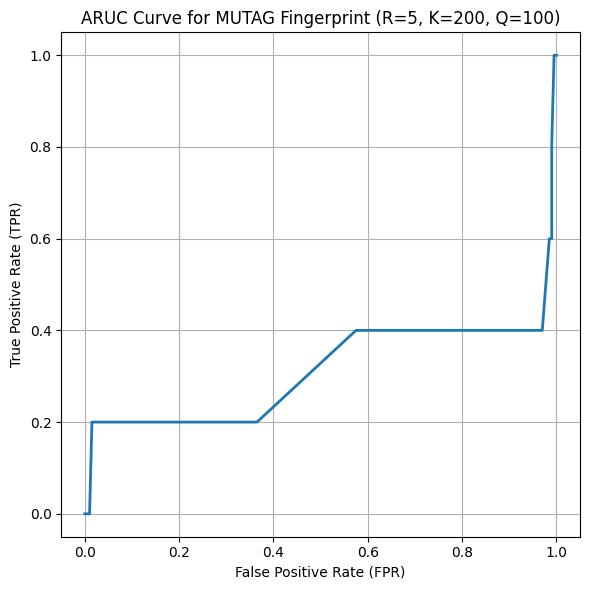

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Block 5 & 6 (Updated): Extract Fingerprints & Compute ARUC Curve with Q = 100
# ─────────────────────────────────────────────────────────────────────────────

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from sklearn.metrics.pairwise import cosine_similarity

# ─────────────────────────────────────────────────────────────────────────────
# Re‐use GINModel and FingerprintNetMLP definitions from Block 4
# (Copy these classes if they’re not already in your notebook.)
# ─────────────────────────────────────────────────────────────────────────────

class GINModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv1 = GINConv(nn1)

        nn2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv2 = GINConv(nn2)

        nn3 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels)
        )
        self.conv3 = GINConv(nn3)

        self.dropout = dropout
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        pooled = global_add_pool(x, batch)   # [batch_size, hidden_channels]
        logits = self.lin(pooled)            # [batch_size, num_classes]
        return logits, pooled                # return both logits and embedding

class FingerprintNetMLP(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden_dim=64, dropout=0.5):
        super().__init__()
        # Fixed random key (no gradients):
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        # MLP: (embed_dim + key_dim) → hidden_dim → 2 logits
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, emb_batch):
        # emb_batch: [batch_size, embed_dim]
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)  # [batch_size, embed_dim + key_dim]
        return self.net(x)                          # [batch_size, 2]

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload MUTAG, victim_model, U, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load MUTAG dataset
dataset_mutag = TUDataset(
    root='/tmp/MUTAG',
    name='MUTAG',
    transform=OneHotDegree(max_degree=10)
).shuffle()

# 2) Split into train/test
train_dataset = dataset_mutag[:150]
test_dataset  = dataset_mutag[150:]

# 3) Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 4) Reload the “victim” GIN from Block 2
victim_model = GINModel(
    in_channels=dataset_mutag.num_node_features,
    hidden_channels=64,
    num_classes=dataset_mutag.num_classes,
    dropout=0.5
).to(device)
victim_model.load_state_dict(torch.load("victim_mutag.pth", map_location=device))
victim_model.eval()

# 5) Reload the fingerprint network U from Block 4 (in memory or from a saved file)
U = FingerprintNetMLP(embed_dim=64, key_dim=64, hidden_dim=64, dropout=0.5).to(device)
# If you saved U as "fingerprint_U.pth", you can uncomment:
# U.load_state_dict(torch.load("fingerprint_U.pth", map_location=device))
U.eval()

# 6) Collect all 200 negative variant file paths
neg_paths = [
    f"negative_mutag_variants/negative_mutag_{i:03d}.pth"
    for i in range(200)
]


# ─────────────────────────────────────────────────────────────────────────────
# (B) Choose a fixed query set of Q = 150 MUTAG graphs:
# ─────────────────────────────────────────────────────────────────────────────

# For Q = 150:
query_graphs = list(test_dataset) + list(train_dataset[: (150 - len(test_dataset)) ])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

# Or for Q = 188:
# query_graphs = list(dataset_mutag)
# query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)


# ─────────────────────────────────────────────────────────────────────────────
# (C) Define helper to extract a single model’s “fingerprint vector”
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint(model: GINModel, U_net: FingerprintNetMLP, loader: DataLoader) -> np.ndarray:
    model.eval()
    U_net.eval()

    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            _, pooled = model(batch.x, batch.edge_index, batch.batch)
            pooled_list.append(pooled.cpu())
    # Concatenate all pooled embeddings: shape [Q, 64]
    all_pooled = torch.cat(pooled_list, dim=0)

    # Pass through U’s net up to before final linear:
    # U_net.net[:-1] = [Linear, ReLU, Dropout]
    features = U_net.net[:-1](torch.cat(
        [all_pooled.to(device),
         U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)],
        dim=1
    ))
    # Detach gradients, average over Q to get [64]
    fingerprint_vec = features.detach().mean(dim=0).cpu().numpy()
    return fingerprint_vec

# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim
# ─────────────────────────────────────────────────────────────────────────────

fp_victim = extract_fingerprint(victim_model, U, query_loader)  # shape [64]

# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200 × 64)
# ─────────────────────────────────────────────────────────────────────────────

fp_negatives = []
for path in neg_paths:
    neg_model = GINModel(
        in_channels=dataset_mutag.num_node_features,
        hidden_channels=64,
        num_classes=dataset_mutag.num_classes,
        dropout=0.5
    ).to(device)
    neg_model.load_state_dict(torch.load(path, map_location=device))
    neg_model.eval()

    fp_neg_i = extract_fingerprint(neg_model, U, query_loader)
    fp_negatives.append(fp_neg_i)

fp_negatives = np.stack(fp_negatives, axis=0)  # shape [200, 64]

# ─────────────────────────────────────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────────────
# (F) Retrain fewer epochs for “retrained victims” (25 epochs now):
# ─────────────────────────────────────────────────────────────────────────────

def train_victim(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed)
    random.seed(seed)
    model = GINModel(
        in_channels=dataset_mutag.num_node_features,
        hidden_channels=64,
        num_classes=dataset_mutag.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    train_loader_local = DataLoader(train_dataset, batch_size=32, shuffle=True)
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in train_loader_local:
            batch = batch.to(device)
            out, _ = model(batch.x, batch.edge_index, batch.batch)
            labels = batch.y.view(-1)
            loss = loss_fn(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model


R = 5
fp_retrained_list = []
for seed in range(R):
    retrained = train_victim(seed + 100, num_epochs=50)
    fp_rt = extract_fingerprint(retrained, U, query_loader)
    fp_retrained_list.append(fp_rt)

fp_retrained = np.stack(fp_retrained_list, axis=0)  # shape [R, 64]

# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity “robustness” and “uniqueness” scores
# ─────────────────────────────────────────────────────────────────────────────

fp_victim_2d     = fp_victim.reshape(1, -1)  # [1, 64]
robustness_scores = cosine_similarity(fp_victim_2d, fp_retrained)[0]  # [R]
uniqueness_scores = cosine_similarity(fp_victim_2d, fp_negatives)[0]   # [200]

# ─────────────────────────────────────────────────────────────────────────────
# (H) Build the ARUC curve: sweep threshold τ ∈ [-1, 1]
#     • TPR(τ) = mean(robustness_scores ≥ τ)
#     • FPR(τ) = mean(uniqueness_scores ≥ τ)
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []
FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_scores >= τ))
    FPR.append(np.mean(uniqueness_scores >= τ))
TPR = np.array(TPR)
FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot the ARUC curve (FPR vs. TPR)
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6, 6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC Curve for MUTAG Fingerprint (R=5, K=200, Q=100)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# (Example for CUDA 11.3 + PyTorch 1.13; adjust versions as needed)
!pip install torch torchvision torchaudio
!pip install torch-geometric



In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [ ]:
# ── 1.2.1 ENZYMES ──────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root='/tmp/ENZYMES',
    name='ENZYMES',
    transform=OneHotDegree(max_degree=10)
).shuffle()

# According to the paper: ENZYMES has 600 graphs; split 70/10/20 = 420/60/120
train_ENZ = dataset_ENZ[:420]    # first 420 graphs
val_ENZ   = dataset_ENZ[420:480] # next 60 graphs
test_ENZ  = dataset_ENZ[480:]    # last 120 graphs

print(f"ENZ: total={len(dataset_ENZ)} | train={len(train_ENZ)} | val={len(val_ENZ)} | test={len(test_ENZ)}")


Processing...


ENZ: total=600 | train=420 | val=60 | test=120


Done!


In [ ]:
# ── 1.2.2 PROTEINS ─────────────────────────────────────────────────────────
dataset_PRO = TUDataset(
    root='/tmp/PROTEINS',
    name='PROTEINS',
    transform=OneHotDegree(max_degree=10)
).shuffle()

# PROTEINS has 1113 graphs; 70%≈779, 10%≈111, 20%≈223
train_PRO = dataset_PRO[:779]
val_PRO   = dataset_PRO[779: 779+111]
test_PRO  = dataset_PRO[779+111:]

print(f"PRO: total={len(dataset_PRO)} | train={len(train_PRO)} | val={len(val_PRO)} | test={len(test_PRO)}")


Processing...


PRO: total=1113 | train=779 | val=111 | test=223


Done!


In [ ]:
# ── 1.3 GCNMean ────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)   # [batch_size, hidden_channels]
        return self.lin(x)               # [batch_size, num_classes]


# ── 1.3 GCNDiff ────────────────────────────────────────────────────────────
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        # Note: “Diff” variant often means we add a skip connection after each layer.
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x0 = x  # initial input
        x1 = F.relu(self.conv1(x0, edge_index)) + x0   # residual
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2 = F.relu(self.conv2(x1, edge_index)) + x1   # residual
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        x3 = F.relu(self.conv3(x2, edge_index)) + x2   # residual
        x3 = global_mean_pool(x3, batch)
        return self.lin(x3)


# ── 1.3 SAGEMean ───────────────────────────────────────────────────────────
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


# ── 1.3 SAGEDiff ───────────────────────────────────────────────────────────
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x0 = x
        x1 = F.relu(self.conv1(x0, edge_index)) + x0
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        x2 = F.relu(self.conv2(x1, edge_index)) + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        x3 = F.relu(self.conv3(x2, edge_index)) + x2
        x3 = global_mean_pool(x3, batch)
        return self.lin(x3)


In [ ]:
def train_graph_cls_victim(
    model: nn.Module,
    train_dataset: TUDataset,
    val_dataset: TUDataset,
    test_dataset: TUDataset,
    model_name: str,
    num_epochs: int = 200,
    batch_size: int = 32,
    lr: float = 0.01,
    weight_decay: float = 5e-4
):
    """
    Trains `model` on train_dataset, monitors val_dataset, and returns test accuracy.
    Saves the best‐validation checkpoint as "{model_name}.pth".
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_state   = None

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        total_loss = 0.0; correct = 0; total = 0
        for batch in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # logits [batch_size, num_classes]
            labels = batch.y.view(-1)
            loss = loss_fn(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.num_graphs
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += batch.num_graphs

        train_acc = correct / total

        # Validation
        model.eval()
        correct_val = 0; total_val = 0
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
                correct_val += (out == batch.y.view(-1)).sum().item()
                total_val += batch.num_graphs
        val_acc = correct_val / total_val

        # Save best‐val checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state   = model.state_dict()

        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"[{model_name}] Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Load best‐val before computing final test accuracy
    if best_state is not None:
        model.load_state_dict(best_state)

    # Test accuracy
    model.eval()
    correct_test = 0; total_test = 0
    with torch.no_grad():
        for batch in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct_test += (out == batch.y.view(-1)).sum().item()
            total_test += batch.num_graphs
    test_acc = correct_test / total_test

    # Save final best‐val weights
    torch.save(model.state_dict(), f"victim_{model_name}.pth")
    print(f"[{model_name}] Best val acc {best_val_acc:.4f} → saved to victim_{model_name}.pth | Test Acc {test_acc:.4f}")

    return test_acc


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Load ENZYMES (70∶10∶20 split)
# ─────────────────────────────────────────────────────────────────────────────
dataset_ENZ = TUDataset(
    root='/tmp/ENZYMES',
    name='ENZYMES',
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]    # 420 graphs
val_ENZ   = dataset_ENZ[420:480] # 60 graphs
test_ENZ  = dataset_ENZ[480:]    # 120 graphs

print(f"ENZYMES: total={len(dataset_ENZ)} | train={len(train_ENZ)} | val={len(val_ENZ)} | test={len(test_ENZ)}")


# ─────────────────────────────────────────────────────────────────────────────
# 2. Define GCNMean, GCNDiff, SAGEMean, SAGEDiff (with corrected residuals)
# ─────────────────────────────────────────────────────────────────────────────

# ── 2.1 GCNMean ─────────────────────────────────────────────────────────────
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


# ── 2.2 Corrected GCNDiff ─────────────────────────────────────────────────────
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        # If in_channels != hidden_channels, project input x0 → hidden_channels before adding
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        # Project x0 if needed
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        # Layer 1 + residual
        h1 = F.relu(self.conv1(x0, edge_index))      # [num_nodes, hidden_channels]
        x1 = h1 + x0_proj                             # project‐skip + conv output
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # Layer 2 + residual
        h2 = F.relu(self.conv2(x1, edge_index))       # [num_nodes, hidden_channels]
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        # Layer 3 + residual
        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)             # [batch_size, hidden_channels]
        return self.lin(out)                          # [batch_size, num_classes]


# ── 2.3 SAGEMean ─────────────────────────────────────────────────────────────
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


# ── 2.4 Corrected SAGEDiff ────────────────────────────────────────────────────
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        # Project inputs if needed
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        # Layer 1 + residual
        h1 = F.relu(self.conv1(x0, edge_index))       # [num_nodes, hidden_channels]
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # Layer 2 + residual
        h2 = F.relu(self.conv2(x1, edge_index))       # [num_nodes, hidden_channels]
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        # Layer 3 + residual
        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)              # [batch_size, hidden_channels]
        return self.lin(out)                           # [batch_size, num_classes]


# ─────────────────────────────────────────────────────────────────────────────
# 3. Train all four victims on ENZYMES
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3.1 GCNMean
model_name = "ENZ_GCNMean"
model = GCNMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_GCNMean = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)

# 3.2 GCNDiff
model_name = "ENZ_GCNDiff"
model = GCNDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_GCNDiff = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)

# 3.3 SAGEMean
model_name = "ENZ_SAGEMean"
model = SAGEMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_SAGEMean = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)

# 3.4 SAGEDiff
model_name = "ENZ_SAGEDiff"
model = SAGEDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
)
test_acc_ENZ_SAGEDiff = train_graph_cls_victim(
    model=model,
    train_dataset=train_ENZ,
    val_dataset=val_ENZ,
    test_dataset=test_ENZ,
    model_name=model_name
)


ENZYMES: total=600 | train=420 | val=60 | test=120
[ENZ_GCNMean] Epoch 001 | Train Acc: 0.1357 | Val Acc: 0.1000
[ENZ_GCNMean] Epoch 020 | Train Acc: 0.2738 | Val Acc: 0.2500
[ENZ_GCNMean] Epoch 040 | Train Acc: 0.3190 | Val Acc: 0.3667
[ENZ_GCNMean] Epoch 060 | Train Acc: 0.3619 | Val Acc: 0.3167
[ENZ_GCNMean] Epoch 080 | Train Acc: 0.3810 | Val Acc: 0.4000
[ENZ_GCNMean] Epoch 100 | Train Acc: 0.4143 | Val Acc: 0.3000
[ENZ_GCNMean] Epoch 120 | Train Acc: 0.4071 | Val Acc: 0.3500
[ENZ_GCNMean] Epoch 140 | Train Acc: 0.4119 | Val Acc: 0.3667
[ENZ_GCNMean] Epoch 160 | Train Acc: 0.4452 | Val Acc: 0.3000
[ENZ_GCNMean] Epoch 180 | Train Acc: 0.4167 | Val Acc: 0.2667
[ENZ_GCNMean] Epoch 200 | Train Acc: 0.4810 | Val Acc: 0.3167
[ENZ_GCNMean] Best val acc 0.4000 → saved to victim_ENZ_GCNMean.pth | Test Acc 0.3167
[ENZ_GCNDiff] Epoch 001 | Train Acc: 0.1881 | Val Acc: 0.1000
[ENZ_GCNDiff] Epoch 020 | Train Acc: 0.3119 | Val Acc: 0.4167
[ENZ_GCNDiff] Epoch 040 | Train Acc: 0.3524 | Val Acc: 0.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 0) Make sure these top-level folders exist (they’ll be relative to your notebook)
os.makedirs("ENZYMES", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("variants/ENZ_GCNMean/positive", exist_ok=True)
os.makedirs("variants/ENZ_GCNMean/negative", exist_ok=True)
os.makedirs("variants/ENZ_GCNDiff/positive", exist_ok=True)
os.makedirs("variants/ENZ_GCNDiff/negative", exist_ok=True)
os.makedirs("variants/ENZ_SAGEMean/positive", exist_ok=True)
os.makedirs("variants/ENZ_SAGEMean/negative", exist_ok=True)
os.makedirs("variants/ENZ_SAGEDiff/positive", exist_ok=True)
os.makedirs("variants/ENZ_SAGEDiff/negative", exist_ok=True)

# 1) Load ENZYMES without an absolute path—this creates a folder "./ENZYMES"
dataset_ENZ = TUDataset(root="ENZYMES",
                        name="ENZYMES",
                        transform=OneHotDegree(max_degree=10)).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

print(f"ENZYMES: total={len(dataset_ENZ)} | train={len(train_ENZ)} | val={len(val_ENZ)} | test={len(test_ENZ)}")

# 2) Define architectures (GCNMean, corrected GCNDiff, SAGEMean, corrected SAGEDiff)

class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 3) Helper to train & save victims (again, saves to "./checkpoints/victim_<model_name>.pth")
def train_graph_cls_victim(model, train_dataset, val_dataset, test_dataset, model_name,
                           num_epochs=200, batch_size=32, lr=0.01, weight_decay=5e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    best_val_acc, best_state = 0.0, None

    for epoch in range(1, num_epochs+1):
        model.train()
        total_correct, total = 0, 0
        for batch in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            total_correct += (preds == batch.y.view(-1)).sum().item()
            total += batch.num_graphs

        train_acc = total_correct / total

        # Validate
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
                batch = batch.to(device)
                preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
                val_correct += (preds == batch.y.view(-1)).sum().item()
                val_total += batch.num_graphs
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc, best_state = val_acc, model.state_dict()

        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"[{model_name}] Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    # Test
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for batch in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            test_correct += (preds == batch.y.view(-1)).sum().item()
            test_total += batch.num_graphs
    test_acc = test_correct / test_total

    torch.save(model.state_dict(), f"checkpoints/victim_{model_name}.pth")
    print(f"[{model_name}] Best val acc {best_val_acc:.4f} → saved to checkpoints/victim_{model_name}.pth | Test Acc {test_acc:.4f}")
    return test_acc

# 4) Train each ENZ “victim” without any absolute paths
test_acc_ENZ_GCNMean = train_graph_cls_victim(
    GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_GCNMean"
)

test_acc_ENZ_GCNDiff = train_graph_cls_victim(
    GCNDiff(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_GCNDiff"
)

test_acc_ENZ_SAGEMean = train_graph_cls_victim(
    SAGEMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_SAGEMean"
)

test_acc_ENZ_SAGEDiff = train_graph_cls_victim(
    SAGEDiff(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5),
    train_ENZ, val_ENZ, test_ENZ, "ENZ_SAGEDiff"
)

# 5) Now generate positive/negative variants for ENZ_GCNMean, using relative paths:
# ─────────────────────────────────────────────────────────────────────────────

# Positive variants for ENZ_GCNMean
for vid in range(200):
    model = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_ENZ_GCNMean.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, param in model.named_parameters():
            if "lin" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill GCNMean → SAGEMean
        class SAGEMean(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = SAGEConv(in_channels, hidden_channels)
                self.conv2  = SAGEConv(hidden_channels, hidden_channels)
                self.conv3  = SAGEConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout
            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = SAGEMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature ** 2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_weights = []
        for param in model.parameters():
            if param.requires_grad:
                all_weights.append(param.view(-1).cpu().abs())
        all_weights = torch.cat(all_weights)
        threshold = torch.quantile(all_weights, 0.10)
        with torch.no_grad():
            for param in model.parameters():
                mask = param.abs() < threshold.to(param.device)
                param[mask] = 0.0

    torch.save(model.state_dict(), f"variants/ENZ_GCNMean/positive/positive_{vid:03d}.pth")

print("Done 200 positive variants for ENZ_GCNMean.")

# Negative variants for ENZ_GCNMean
for vid in range(200):
    model = GCNMean(dataset_ENZ.num_node_features, 64, dataset_ENZ.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid)
    random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/ENZ_GCNMean/negative/negative_{vid:03d}.pth")

print("Done 200 negative variants for ENZ_GCNMean.")


Processing...
Done!


ENZYMES: total=600 | train=420 | val=60 | test=120
[ENZ_GCNMean] Epoch 001 | Train Acc: 0.1619 | Val Acc: 0.1333
[ENZ_GCNMean] Epoch 020 | Train Acc: 0.3262 | Val Acc: 0.3833
[ENZ_GCNMean] Epoch 040 | Train Acc: 0.3500 | Val Acc: 0.3667
[ENZ_GCNMean] Epoch 060 | Train Acc: 0.3833 | Val Acc: 0.3333
[ENZ_GCNMean] Epoch 080 | Train Acc: 0.3833 | Val Acc: 0.3333
[ENZ_GCNMean] Epoch 100 | Train Acc: 0.4286 | Val Acc: 0.3167
[ENZ_GCNMean] Epoch 120 | Train Acc: 0.4476 | Val Acc: 0.4000
[ENZ_GCNMean] Epoch 140 | Train Acc: 0.4238 | Val Acc: 0.3500
[ENZ_GCNMean] Epoch 160 | Train Acc: 0.4595 | Val Acc: 0.3833
[ENZ_GCNMean] Epoch 180 | Train Acc: 0.4690 | Val Acc: 0.3333
[ENZ_GCNMean] Epoch 200 | Train Acc: 0.4452 | Val Acc: 0.3167
[ENZ_GCNMean] Best val acc 0.4333 → saved to checkpoints/victim_ENZ_GCNMean.pth | Test Acc 0.3083
[ENZ_GCNDiff] Epoch 001 | Train Acc: 0.1833 | Val Acc: 0.2167
[ENZ_GCNDiff] Epoch 020 | Train Acc: 0.3214 | Val Acc: 0.3667
[ENZ_GCNDiff] Epoch 040 | Train Acc: 0.4048 |

KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load ENZ (relative to "./ENZYMES" folder)
dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) Define the same GCNMean as before
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 3) Reload victim_ENZ_GCNMean
victim_path = os.path.join("checkpoints", "victim_ENZ_GCNMean.pth")
victim_ENZ_GCNMean = GCNMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_GCNMean.load_state_dict(torch.load(victim_path = os.path.join("checkpoints", "victim_ENZ_GCNMean.pth")
, map_location=device))
victim_ENZ_GCNMean.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define and train U_ENZ_GCNMean (FingerprintNetMLP) – Block 4
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)  # [batch_size, 128]
        return self.net(x)                          # [batch_size, 2]

U_ENZ_GCNMean = FingerprintNetMLP_ENZ(
    embed_dim=64,
    key_dim=64,
    hidden1=256,
    hidden2=128,
    hidden3=64,
    dropout=0.5
).to(device)

# 4) Collect 100 “victim” embeddings (label=1) from train_ENZ[:100]
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        # We need the 64‐dim “pooled” output from the last conv:
        # Modify GCNMean to also return its pooled vector if needed; here we recompute:
        x1 = F.relu(victim_ENZ_GCNMean.conv1(batch.x, batch.edge_index))
        x1 = F.dropout(x1, p=victim_ENZ_GCNMean.dropout, training=False)
        x2 = F.relu(victim_ENZ_GCNMean.conv2(x1, batch.edge_index))
        x2 = F.dropout(x2, p=victim_ENZ_GCNMean.dropout, training=False)
        x3 = F.relu(victim_ENZ_GCNMean.conv3(x2, batch.edge_index))
        pooled = global_mean_pool(x3, batch.batch)  # [batch_size, 64]
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings from 20 negative variants (5 each)
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # = 5

for neg_i in range(num_neg_models):
    neg_model = GCNMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNMean", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            x1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            x1 = F.dropout(x1, p=neg_model.dropout, training=False)
            x2 = F.relu(neg_model.conv2(x1, batch.edge_index))
            x2 = F.dropout(x2, p=neg_model.dropout, training=False)
            x3 = F.relu(neg_model.conv3(x2, batch.edge_index))
            pooled_neg = global_mean_pool(x3, batch.batch)  # [batch_size, 64]
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s training loader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([pair[0] for pair in fp_pairs], dim=0)  # [200, 64]
labels   = torch.tensor([pair[1] for pair in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

print("U’s training set ready: features [200,64], labels [200]")

# Train U_ENZ_GCNMean
opt_U = torch.optim.Adam(U_ENZ_GCNMean.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_GCNMean.train()
    total_loss = 0.0
    correct_fp = 0
    total_fp = 0

    for (emb_batch, lbl_batch) in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)

        logits = U_ENZ_GCNMean(emb_batch)     # [batch_size, 2]
        loss = loss_fn_fp(logits, lbl_batch)

        opt_U.zero_grad()
        loss.backward()
        opt_U.step()

        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_loss = total_loss / total_fp
    train_acc  = correct_fp / total_fp
    print(f"[U_ENZ_GCNMean] Epoch {epoch:03d} | U-loss: {train_loss:.4f} | U-acc: {train_acc:.4f}")

    if train_acc >= 0.95:
        print(f"→ Reached 95% accuracy at epoch {epoch}, stopping early.")
        break

U_ENZ_GCNMean.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_GCNMean.state_dict(), "checkpoints/U_ENZ_GCNMean.pth")
print("Finished training U_ENZ_GCNMean; saved to checkpoints/U_ENZ_GCNMean.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper to extract a single model’s fingerprint
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval()
    U_net.eval()
    pooled_list = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            x1 = F.relu(model.conv1(batch.x, batch.edge_index))
            x1 = F.dropout(x1, p=model.dropout, training=False)
            x2 = F.relu(model.conv2(x1, batch.edge_index))
            x2 = F.dropout(x2, p=model.dropout, training=False)
            x3 = F.relu(model.conv3(x2, batch.edge_index))
            pooled = global_mean_pool(x3, batch.batch)  # [batch_size, 64]
            pooled_list.append(pooled.cpu())

    all_pooled = torch.cat(pooled_list, dim=0)  # [Q, 64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q, 128]
        features = U_net.net[:-1](x)  # [Q, hidden3=64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

# Build query_loader from test_ENZ[:100]
query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_GCNMean, U_ENZ_GCNMean, query_loader)  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200 × 64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = GCNMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNMean", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_GCNMean, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200, 64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R = 5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed)
    random.seed(seed)
    model = GCNMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            labels = batch.y.view(-1)
            loss = loss_fn(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_GCNMean, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5, 64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity scores: robustness (R) and uniqueness (K)
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)  # [1, 64]
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # shape [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # shape [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: sweep τ ∈ [-1, 1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []
FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR)
FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot and save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6, 6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ GCNMean (R=5, K=200, Q=100)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ARUC_ENZ_GCNMean_Q100.png")
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, GCNDiff victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) Corrected GCNDiff definition (same as you used when training)
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 3) Reload victim_ENZ_GCNDiff
victim_path = os.path.join("checkpoints", "victim_ENZ_GCNDiff.pth")
victim_ENZ_GCNDiff = GCNDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_GCNDiff.load_state_dict(torch.load(victim_path, map_location=device))
victim_ENZ_GCNDiff.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define & train U_ENZ_GCNDiff
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

U_ENZ_GCNDiff = FingerprintNetMLP_ENZ().to(device)

# 4) Collect 100 “victim” embeddings with label=1 (train_ENZ[:100])
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        # Manually extract pooled 64‐d vector:
        h1 = F.relu(victim_ENZ_GCNDiff.conv1(batch.x, batch.edge_index))
        h1 = F.dropout(h1, p=victim_ENZ_GCNDiff.dropout, training=False)
        h2 = F.relu(victim_ENZ_GCNDiff.conv2(h1, batch.edge_index))
        h2 = F.dropout(h2, p=victim_ENZ_GCNDiff.dropout, training=False)
        h3 = F.relu(victim_ENZ_GCNDiff.conv3(h2, batch.edge_index))
        pooled = global_mean_pool(h3, batch.batch)  # [batch_size,64]
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings from 20 negative models (5 per model)
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # 5

for neg_i in range(num_neg_models):
    neg_model = GCNDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNDiff", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            h1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=neg_model.dropout, training=False)
            h2 = F.relu(neg_model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=neg_model.dropout, training=False)
            h3 = F.relu(neg_model.conv3(h2, batch.edge_index))
            pooled_neg = global_mean_pool(h3, batch.batch)  # [batch_size,64]
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s training DataLoader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([p[0] for p in fp_pairs], dim=0)  # [200,64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

# Train U_ENZ_GCNDiff
opt_U = torch.optim.Adam(U_ENZ_GCNDiff.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_GCNDiff.train()
    total_loss = 0.0; correct_fp = 0; total_fp = 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        logits = U_ENZ_GCNDiff(emb_batch)
        loss = loss_fn_fp(logits, lbl_batch)
        opt_U.zero_grad()
        loss.backward()
        opt_U.step()
        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"[U_ENZ_GCNDiff] Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% at epoch {epoch}, stopping")
        break

U_ENZ_GCNDiff.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_GCNDiff.state_dict(), "checkpoints/U_ENZ_GCNDiff.pth")
print("Saved U_ENZ_GCNDiff to checkpoints/U_ENZ_GCNDiff.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper: extract graph‐cls fingerprint using U
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval(); U_net.eval()
    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            h1 = F.relu(model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=model.dropout, training=False)
            h2 = F.relu(model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=model.dropout, training=False)
            h3 = F.relu(model.conv3(h2, batch.edge_index))
            pooled = global_mean_pool(h3, batch.batch)  # [batch_size,64]
            pooled_list.append(pooled.cpu())
    all_pooled = torch.cat(pooled_list, dim=0)  # [Q,64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q,128]
        features = U_net.net[:-1](x)  # [Q,64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_GCNDiff, U_ENZ_GCNDiff, query_loader)


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200×64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = GCNDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_GCNDiff", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()
    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_GCNDiff, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200,64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R=5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ_diff(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed); random.seed(seed)
    model = GCNDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ_diff(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_GCNDiff, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5,64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity: robustness & uniqueness
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)                     # [1,64]
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: thresholds ∈ [−1,1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []; FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR); FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot & save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6,6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ GCNDiff (R=5, K=200, Q=100)")
plt.grid(True); plt.tight_layout()
plt.savefig("ARUC_ENZ_GCNDiff_Q100.png")
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, SAGEMean victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) SAGEMean definition
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 3) Reload victim_ENZ_SAGEMean
victim_path = os.path.join("checkpoints", "victim_ENZ_SAGEMean.pth")
victim_ENZ_SAGEMean = SAGEMean(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_SAGEMean.load_state_dict(torch.load(victim_path, map_location=device))
victim_ENZ_SAGEMean.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define & train U_ENZ_SAGEMean
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

U_ENZ_SAGEMean = FingerprintNetMLP_ENZ().to(device)

# 4) Collect 100 victim embeddings (train_ENZ[:100])
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        h1 = F.relu(victim_ENZ_SAGEMean.conv1(batch.x, batch.edge_index))
        h1 = F.dropout(h1, p=victim_ENZ_SAGEMean.dropout, training=False)
        h2 = F.relu(victim_ENZ_SAGEMean.conv2(h1, batch.edge_index))
        h2 = F.dropout(h2, p=victim_ENZ_SAGEMean.dropout, training=False)
        h3 = F.relu(victim_ENZ_SAGEMean.conv3(h2, batch.edge_index))
        pooled = global_mean_pool(h3, batch.batch)
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings from 20 negative models
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # 5

for neg_i in range(num_neg_models):
    neg_model = SAGEMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEMean", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            h1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=neg_model.dropout, training=False)
            h2 = F.relu(neg_model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=neg_model.dropout, training=False)
            h3 = F.relu(neg_model.conv3(h2, batch.edge_index))
            pooled_neg = global_mean_pool(h3, batch.batch)
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s DataLoader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([p[0] for p in fp_pairs], dim=0)  # [200,64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

opt_U = torch.optim.Adam(U_ENZ_SAGEMean.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_SAGEMean.train()
    total_loss = 0.0; correct_fp = 0; total_fp = 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        logits = U_ENZ_SAGEMean(emb_batch)
        loss = loss_fn_fp(logits, lbl_batch)
        opt_U.zero_grad()
        loss.backward()
        opt_U.step()
        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"[U_ENZ_SAGEMean] Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% at epoch {epoch}, stopping")
        break

U_ENZ_SAGEMean.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_SAGEMean.state_dict(), "checkpoints/U_ENZ_SAGEMean.pth")
print("Saved U_ENZ_SAGEMean to checkpoints/U_ENZ_SAGEMean.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper: extract fingerprint
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval(); U_net.eval()
    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            h1 = F.relu(model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=model.dropout, training=False)
            h2 = F.relu(model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=model.dropout, training=False)
            h3 = F.relu(model.conv3(h2, batch.edge_index))
            pooled = global_mean_pool(h3, batch.batch)
            pooled_list.append(pooled.cpu())
    all_pooled = torch.cat(pooled_list, dim=0)  # [Q,64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q,128]
        features = U_net.net[:-1](x)  # [Q,64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_SAGEMean, U_ENZ_SAGEMean, query_loader)


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200×64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = SAGEMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEMean", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()
    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_SAGEMean, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200,64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R=5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ_sage(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed); random.seed(seed)
    model = SAGEMean(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ_sage(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_SAGEMean, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5,64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity: robustness & uniqueness
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: thresholds ∈ [−1,1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []; FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR); FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot & save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6,6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ SAGEMean (R=5, K=200, Q=100)")
plt.grid(True); plt.tight_layout()
plt.savefig("ARUC_ENZ_SAGEMean_Q100.png")
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch.utils.data import TensorDataset, DataLoader as TorchDL
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ─────────────────────────────────────────────────────────────────────────────
# (A) Reload ENZYMES, SAGEDiff victim, and negative variants
# ─────────────────────────────────────────────────────────────────────────────

dataset_ENZ = TUDataset(
    root="ENZYMES",
    name="ENZYMES",
    transform=OneHotDegree(max_degree=10)
).shuffle()

train_ENZ = dataset_ENZ[:420]
val_ENZ   = dataset_ENZ[420:480]
test_ENZ  = dataset_ENZ[480:]

# 2) Corrected SAGEDiff definition
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 3) Reload victim_ENZ_SAGEDiff
victim_path = os.path.join("checkpoints", "victim_ENZ_SAGEDiff.pth")
victim_ENZ_SAGEDiff = SAGEDiff(
    in_channels=dataset_ENZ.num_node_features,
    hidden_channels=64,
    num_classes=dataset_ENZ.num_classes,
    dropout=0.5
).to(device)
victim_ENZ_SAGEDiff.load_state_dict(torch.load(victim_path, map_location=device))
victim_ENZ_SAGEDiff.eval()

# ─────────────────────────────────────────────────────────────────────────────
# (B) Define & train U_ENZ_SAGEDiff
# ─────────────────────────────────────────────────────────────────────────────

class FingerprintNetMLP_ENZ(nn.Module):
    def __init__(self, embed_dim=64, key_dim=64, hidden1=256, hidden2=128, hidden3=64, dropout=0.5):
        super().__init__()
        self.key = nn.Parameter(torch.randn(key_dim), requires_grad=False)
        self.net = nn.Sequential(
            nn.Linear(embed_dim + key_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden2, hidden3),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden3, 2)
        )

    def forward(self, emb_batch):
        key_rep = self.key.unsqueeze(0).expand(emb_batch.size(0), -1).to(emb_batch.device)
        x = torch.cat([emb_batch, key_rep], dim=1)
        return self.net(x)

U_ENZ_SAGEDiff = FingerprintNetMLP_ENZ().to(device)

# 4) Collect 100 victim embeddings (train_ENZ[:100])
victim_embeddings = []
with torch.no_grad():
    for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
        batch = batch.to(device)
        h1 = F.relu(victim_ENZ_SAGEDiff.conv1(batch.x, batch.edge_index))
        h1 = F.dropout(h1, p=victim_ENZ_SAGEDiff.dropout, training=False)
        h2 = F.relu(victim_ENZ_SAGEDiff.conv2(h1, batch.edge_index))
        h2 = F.dropout(h2, p=victim_ENZ_SAGEDiff.dropout, training=False)
        h3 = F.relu(victim_ENZ_SAGEDiff.conv3(h2, batch.edge_index))
        pooled = global_mean_pool(h3, batch.batch)
        for emb in pooled:
            victim_embeddings.append((emb.cpu(), 1))
assert len(victim_embeddings) == 100

# 5) Collect 100 negative embeddings (20 models × 5 each)
negative_embeddings = []
num_neg_models = 20
embs_per_model  = 100 // num_neg_models  # 5

for neg_i in range(num_neg_models):
    neg_model = SAGEDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEDiff", "negative", f"negative_{neg_i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()

    collected = 0
    with torch.no_grad():
        for batch in DataLoader(train_ENZ[:100], batch_size=32, shuffle=False):
            batch = batch.to(device)
            h1 = F.relu(neg_model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=neg_model.dropout, training=False)
            h2 = F.relu(neg_model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=neg_model.dropout, training=False)
            h3 = F.relu(neg_model.conv3(h2, batch.edge_index))
            pooled_neg = global_mean_pool(h3, batch.batch)
            for emb in pooled_neg:
                if collected >= embs_per_model:
                    break
                negative_embeddings.append((emb.cpu(), 0))
                collected += 1
            if collected >= embs_per_model:
                break

assert len(negative_embeddings) == 100

# 6) Combine, shuffle, and build U’s DataLoader
fp_pairs = victim_embeddings + negative_embeddings
random.shuffle(fp_pairs)

features = torch.stack([p[0] for p in fp_pairs], dim=0)  # [200,64]
labels   = torch.tensor([p[1] for p in fp_pairs], dtype=torch.long)  # [200]

fp_dataset = TensorDataset(features, labels)
fp_loader  = TorchDL(fp_dataset, batch_size=32, shuffle=True)

opt_U = torch.optim.Adam(U_ENZ_SAGEDiff.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn_fp = nn.CrossEntropyLoss()

for epoch in range(1, 101):
    U_ENZ_SAGEDiff.train()
    total_loss = 0.0; correct_fp = 0; total_fp = 0
    for emb_batch, lbl_batch in fp_loader:
        emb_batch = emb_batch.to(device)
        lbl_batch = lbl_batch.to(device)
        logits = U_ENZ_SAGEDiff(emb_batch)
        loss = loss_fn_fp(logits, lbl_batch)
        opt_U.zero_grad()
        loss.backward()
        opt_U.step()
        total_loss += loss.item() * emb_batch.size(0)
        preds = logits.argmax(dim=1)
        correct_fp += (preds == lbl_batch).sum().item()
        total_fp += emb_batch.size(0)

    train_acc = correct_fp / total_fp
    print(f"[U_ENZ_SAGEDiff] Epoch {epoch:03d} | U-loss: {total_loss/total_fp:.4f} | U-acc: {train_acc:.4f}")
    if train_acc >= 0.95:
        print(f"→ Reached 95% at epoch {epoch}, stopping")
        break

U_ENZ_SAGEDiff.eval()
os.makedirs("checkpoints", exist_ok=True)
torch.save(U_ENZ_SAGEDiff.state_dict(), "checkpoints/U_ENZ_SAGEDiff.pth")
print("Saved U_ENZ_SAGEDiff to checkpoints/U_ENZ_SAGEDiff.pth")


# ─────────────────────────────────────────────────────────────────────────────
# (C) Helper: extract fingerprint
# ─────────────────────────────────────────────────────────────────────────────

def extract_fingerprint_graph_cls(model: nn.Module, U_net: nn.Module, loader: DataLoader) -> np.ndarray:
    model.eval(); U_net.eval()
    pooled_list = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            h1 = F.relu(model.conv1(batch.x, batch.edge_index))
            h1 = F.dropout(h1, p=model.dropout, training=False)
            h2 = F.relu(model.conv2(h1, batch.edge_index))
            h2 = F.dropout(h2, p=model.dropout, training=False)
            h3 = F.relu(model.conv3(h2, batch.edge_index))
            pooled = global_mean_pool(h3, batch.batch)
            pooled_list.append(pooled.cpu())
    all_pooled = torch.cat(pooled_list, dim=0)  # [Q,64]
    with torch.no_grad():
        key_rep = U_net.key.unsqueeze(0).expand(all_pooled.size(0), -1).to(device)
        x = torch.cat([all_pooled.to(device), key_rep], dim=1)  # [Q,128]
        features = U_net.net[:-1](x)  # [Q,64]
    return features.detach().mean(dim=0).cpu().numpy()  # [64]


# ─────────────────────────────────────────────────────────────────────────────
# (D) Extract fp_victim (Q=100)
# ─────────────────────────────────────────────────────────────────────────────

query_graphs = list(test_ENZ[:100])
query_loader = DataLoader(query_graphs, batch_size=32, shuffle=False)

fp_victim_ENZ = extract_fingerprint_graph_cls(victim_ENZ_SAGEDiff, U_ENZ_SAGEDiff, query_loader)


# ─────────────────────────────────────────────────────────────────────────────
# (E) Extract fp_negatives (200×64)
# ─────────────────────────────────────────────────────────────────────────────

fp_neg_ENZ = []
for i in range(200):
    neg_model = SAGEDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    neg_path = os.path.join("variants", "ENZ_SAGEDiff", "negative", f"negative_{i:03d}.pth")
    neg_model.load_state_dict(torch.load(neg_path, map_location=device))
    neg_model.eval()
    fp_neg_ENZ.append(extract_fingerprint_graph_cls(neg_model, U_ENZ_SAGEDiff, query_loader))

fp_neg_ENZ = np.stack(fp_neg_ENZ, axis=0)  # [200,64]


# ─────────────────────────────────────────────────────────────────────────────
# (F) Extract fp_retrained_victims (R=5, 10 epochs)
# ─────────────────────────────────────────────────────────────────────────────

def train_graph_cls_repl_ENZ_sage_diff(seed: int, num_epochs: int = 10):
    torch.manual_seed(seed); random.seed(seed)
    model = SAGEDiff(
        in_channels=dataset_ENZ.num_node_features,
        hidden_channels=64,
        num_classes=dataset_ENZ.num_classes,
        dropout=0.5
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, num_epochs + 1):
        model.train()
        for batch in DataLoader(train_ENZ, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

fp_rt_ENZ_list = []
for seed in range(5):
    rt_model = train_graph_cls_repl_ENZ_sage_diff(seed + 100, num_epochs=10)
    fp_rt_ENZ_list.append(extract_fingerprint_graph_cls(rt_model, U_ENZ_SAGEDiff, query_loader))

fp_rt_ENZ = np.stack(fp_rt_ENZ_list, axis=0)  # [5,64]


# ─────────────────────────────────────────────────────────────────────────────
# (G) Compute cosine‐similarity: robustness & uniqueness
# ─────────────────────────────────────────────────────────────────────────────

fp_v2 = fp_victim_ENZ.reshape(1, -1)
robustness_ENZ = cosine_similarity(fp_v2, fp_rt_ENZ)[0]   # [5]
uniqueness_ENZ = cosine_similarity(fp_v2, fp_neg_ENZ)[0]  # [200]


# ─────────────────────────────────────────────────────────────────────────────
# (H) Build ARUC: thresholds ∈ [−1,1]
# ─────────────────────────────────────────────────────────────────────────────

thresholds = np.linspace(-1.0, 1.0, 100)
TPR = []; FPR = []
for τ in thresholds:
    TPR.append(np.mean(robustness_ENZ >= τ))
    FPR.append(np.mean(uniqueness_ENZ >= τ))
TPR = np.array(TPR); FPR = np.array(FPR)

# ─────────────────────────────────────────────────────────────────────────────
# (I) Plot & save ARUC
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(6,6))
plt.plot(FPR, TPR, linewidth=2)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ARUC: ENZ SAGEDiff (R=5, K=200, Q=100)")
plt.grid(True); plt.tight_layout()
plt.savefig("ARUC_ENZ_SAGEDiff_Q100.png")
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Install PyG (only run once per notebook; comment it out afterwards)
# ─────────────────────────────────────────────────────────────────────────────
!pip install torch torchvision torchaudio --quiet
!pip install torch-scatter -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-sparse   -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-cluster  -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-$(python3 -c "import torch; print(torch.__version__.split('+')[0] )")+cu$(nvidia-smi | grep -Po '(?<=CUDA Version: )\d+\.\d+')/download.html --quiet
!pip install torch-geometric --quiet

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load & split NCI1
# ─────────────────────────────────────────────────────────────────────────────
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import OneHotDegree
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, global_mean_pool

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create local folders if needed
os.makedirs("NCI1", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("variants/NCI1_GCNMean/positive", exist_ok=True)
os.makedirs("variants/NCI1_GCNMean/negative", exist_ok=True)
os.makedirs("variants/NCI1_GCNDiff/positive", exist_ok=True)
os.makedirs("variants/NCI1_GCNDiff/negative", exist_ok=True)
os.makedirs("variants/NCI1_SAGEMean/positive", exist_ok=True)
os.makedirs("variants/NCI1_SAGEMean/negative", exist_ok=True)
os.makedirs("variants/NCI1_SAGEDiff/positive", exist_ok=True)
os.makedirs("variants/NCI1_SAGEDiff/negative", exist_ok=True)

# Download and split (70∶10∶20)
dataset_NCI1 = TUDataset(
    root="NCI1",
    name="NCI1",
    transform=OneHotDegree(max_degree=10)
).shuffle()

n = len(dataset_NCI1)
n_train = int(0.70 * n)
n_val   = int(0.10 * n)
train_NCI1 = dataset_NCI1[:n_train]
val_NCI1   = dataset_NCI1[n_train : n_train + n_val]
test_NCI1  = dataset_NCI1[n_train + n_val : ]

print(f"NCI1: total={n}   | train={len(train_NCI1)}   | val={len(val_NCI1)}   | test={len(test_NCI1)}")


# ─────────────────────────────────────────────────────────────────────────────
# 2) Define four victim architectures
# ─────────────────────────────────────────────────────────────────────────────

# 2.1 GCNMean
class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 2.2 GCNDiff (with projection skip)
class GCNDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = GCNConv(in_channels, hidden_channels)
        self.conv2  = GCNConv(hidden_channels, hidden_channels)
        self.conv3  = GCNConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)

# 2.3 SAGEMean
class SAGEMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

# 2.4 SAGEDiff (with projection skip)
class SAGEDiff(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
        super().__init__()
        self.conv1  = SAGEConv(in_channels, hidden_channels)
        self.conv2  = SAGEConv(hidden_channels, hidden_channels)
        self.conv3  = SAGEConv(hidden_channels, hidden_channels)
        self.lin    = nn.Linear(hidden_channels, num_classes)
        self.dropout = dropout
        if in_channels != hidden_channels:
            self.skip_lin = nn.Linear(in_channels, hidden_channels)
        else:
            self.skip_lin = None

    def forward(self, x, edge_index, batch):
        x0 = x
        x0_proj = self.skip_lin(x0) if (self.skip_lin is not None) else x0

        h1 = F.relu(self.conv1(x0, edge_index))
        x1 = h1 + x0_proj
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        h2 = F.relu(self.conv2(x1, edge_index))
        x2 = h2 + x1
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        h3 = F.relu(self.conv3(x2, edge_index))
        x3 = h3 + x2

        out = global_mean_pool(x3, batch)
        return self.lin(out)


# ─────────────────────────────────────────────────────────────────────────────
# 3) Training helper (same as ENZymES)
# ─────────────────────────────────────────────────────────────────────────────
def train_graph_cls_victim(
    model: nn.Module,
    train_dataset,
    val_dataset,
    test_dataset,
    model_name: str,
    num_epochs: int = 200,
    batch_size: int = 32,
    lr: float = 0.01,
    weight_decay: float = 5e-4
):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    best_state   = None

    for epoch in range(1, num_epochs + 1):
        model.train()
        correct = total = 0
        for batch in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            lbl = batch.y.view(-1)
            loss = loss_fn(out, lbl)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            correct += (preds == lbl).sum().item()
            total += batch.num_graphs
        train_acc = correct / total

        # Validation
        model.eval()
        correct_val = total_val = 0
        with torch.no_grad():
            for batch in DataLoader(val_dataset, batch_size=batch_size, shuffle=False):
                batch = batch.to(device)
                preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
                correct_val += (preds == batch.y.view(-1)).sum().item()
                total_val += batch.num_graphs
        val_acc = correct_val / total_val

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state   = model.state_dict()

        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            print(f"[{model_name}] Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Load best‐val state, then test
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    correct_test = total_test = 0
    with torch.no_grad():
        for batch in DataLoader(test_dataset, batch_size=batch_size, shuffle=False):
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct_test += (preds == batch.y.view(-1)).sum().item()
            total_test += batch.num_graphs
    test_acc = correct_test / total_test

    ckpt_path = os.path.join("checkpoints", f"victim_NCI1_{model_name}.pth")
    torch.save(model.state_dict(), ckpt_path)
    print(f"[{model_name}] Best val acc {best_val_acc:.4f} → saved to {ckpt_path} | Test Acc {test_acc:.4f}")
    return test_acc


# ─────────────────────────────────────────────────────────────────────────────
# 4) Train all four victims on NCI1
# ─────────────────────────────────────────────────────────────────────────────

# 4.1 GCNMean
test_acc_NCI1_GCNMean = train_graph_cls_victim(
    GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "GCNMean"
)

# 4.2 GCNDiff
test_acc_NCI1_GCNDiff = train_graph_cls_victim(
    GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "GCNDiff"
)

# 4.3 SAGEMean
test_acc_NCI1_SAGEMean = train_graph_cls_victim(
    SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "SAGEMean"
)

# 4.4 SAGEDiff
test_acc_NCI1_SAGEDiff = train_graph_cls_victim(
    SAGEDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5),
    train_NCI1, val_NCI1, test_NCI1,
    "SAGEDiff"
)


# ─────────────────────────────────────────────────────────────────────────────
# 5) Generate 200 positive & 200 negative variants per architecture
# ─────────────────────────────────────────────────────────────────────────────

# (a) NCI1_GCNMean
for vid in range(200):
    model = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNMean.pth", map_location=device))
    model.eval()

    strat = vid // 50
    # A) fine‐tune last linear only (10 epochs)
    if strat == 0:
        for name, param in model.named_parameters():
            if "lin" not in name:
                param.requires_grad = False
            else:
                param.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # B) fine‐tune all layers (10 epochs)
    elif strat == 1:
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # C) distill GCNMean → SAGEMean (10 epochs)
    elif strat == 2:
        # SAGEMean “student”
        class SAGEMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = SAGEConv(in_channels, hidden_channels)
                self.conv2  = SAGEConv(hidden_channels, hidden_channels)
                self.conv3  = SAGEConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout

            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = SAGEMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature ** 2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # D) prune 10% weights
    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_GCNMean/positive/positive_{vid:03d}.pth")

# Negative variants for NCI1_GCNMean
for vid in range(200):
    model = GCNMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_GCNMean/negative/negative_{vid:03d}.pth")


# (b) NCI1_GCNDiff
for vid in range(200):
    model = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_GCNDiff.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, p in model.named_parameters():
            if "lin" not in name:
                p.requires_grad = False
            else:
                p.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill → SAGEMean
        class SAGEMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = SAGEConv(in_channels, hidden_channels)
                self.conv2  = SAGEConv(hidden_channels, hidden_channels)
                self.conv3  = SAGEConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout
            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = SAGEMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_GCNDiff/positive/positive_{vid:03d}.pth")

for vid in range(200):
    model = GCNDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_GCNDiff/negative/negative_{vid:03d}.pth")


# (c) NCI1_SAGEMean
for vid in range(200):
    model = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_SAGEMean.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, p in model.named_parameters():
            if "lin" not in name:
                p.requires_grad = False
            else:
                p.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill → GCNMean
        class GCNMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = GCNConv(in_channels, hidden_channels)
                self.conv2  = GCNConv(hidden_channels, hidden_channels)
                self.conv3  = GCNConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout

            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = GCNMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_SAGEMean/positive/positive_{vid:03d}.pth")

for vid in range(200):
    model = SAGEMean(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_SAGEMean/negative/negative_{vid:03d}.pth")


# (d) NCI1_SAGEDiff
for vid in range(200):
    model = SAGEDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    model.load_state_dict(torch.load("checkpoints/victim_NCI1_SAGEDiff.pth", map_location=device))
    model.eval()

    strat = vid // 50
    if strat == 0:
        for name, p in model.named_parameters():
            if "lin" not in name:
                p.requires_grad = False
            else:
                p.requires_grad = True
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 1:
        for p in model.parameters():
            p.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss()
        for epoch in range(1, 11):
            model.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = loss_fn(out, batch.y.view(-1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    elif strat == 2:
        # Distill → GCNMean
        class GCNMean_Student(nn.Module):
            def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.5):
                super().__init__()
                self.conv1  = GCNConv(in_channels, hidden_channels)
                self.conv2  = GCNConv(hidden_channels, hidden_channels)
                self.conv3  = GCNConv(hidden_channels, hidden_channels)
                self.lin    = nn.Linear(hidden_channels, num_classes)
                self.dropout = dropout

            def forward(self, x, edge_index, batch):
                x = F.relu(self.conv1(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv2(x, edge_index))
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.conv3(x, edge_index))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        teacher = model
        student = GCNMean_Student(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
        optimizer = torch.optim.Adam(student.parameters(), lr=0.001)
        temperature = 5.0
        for epoch in range(1, 11):
            student.train()
            for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
                batch = batch.to(device)
                with torch.no_grad():
                    t_logits = teacher(batch.x, batch.edge_index, batch.batch) / temperature
                s_logits = student(batch.x, batch.edge_index, batch.batch) / temperature
                t_probs = F.log_softmax(t_logits, dim=1)
                s_probs = F.log_softmax(s_logits, dim=1)
                loss = F.kl_div(s_probs, t_probs, reduction="batchmean") * (temperature**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    else:
        all_w = []
        for p in model.parameters():
            if p.requires_grad:
                all_w.append(p.view(-1).abs().cpu())
        all_w = torch.cat(all_w)
        thr = torch.quantile(all_w, 0.10)
        with torch.no_grad():
            for p in model.parameters():
                mask = p.abs() < thr.to(p.device)
                p[mask] = 0.0

    torch.save(model.state_dict(), f"variants/NCI1_SAGEDiff/positive/positive_{vid:03d}.pth")

for vid in range(200):
    model = SAGEDiff(dataset_NCI1.num_node_features, 64, dataset_NCI1.num_classes, dropout=0.5).to(device)
    torch.manual_seed(vid); random.seed(vid)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(1, 201):
        model.train()
        for batch in DataLoader(train_NCI1, batch_size=32, shuffle=True):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), f"variants/NCI1_SAGEDiff/negative/negative_{vid:03d}.pth")

print("✅ Finished training NCI1 victims and generating all variants (positive & negative).")
